In [1]:
import sys
print(sys.version)

3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]


In [2]:
import sys
print(sys.executable)


C:\Users\Gurukumar\AppData\Local\Programs\Python\Python311\python.exe


In [3]:
import h5py
import pandas as pd

# === File paths ===
train_path = r"C:\Users\Gurukumar\Desktop\train_dataset.h5"
test_path = r"C:\Users\Gurukumar\Desktop\test_dataset.h5"

# === Function to convert .h5 to DataFrame without altering structure ===
def h5_to_df(file_path):
    with h5py.File(file_path, 'r') as f:
        X = f['InputFeatures']['SoundPressure'][:]
        y = f['TargetLabels']['target'][:]
    
    # Decode class labels (from byte strings to normal strings)
    y = [label.decode('utf-8') if isinstance(label, bytes) else label for label in y]
    
    # If X is 1D, build DataFrame with a single column
    if X.ndim == 1:
        df = pd.DataFrame({'Feature_0': X})
    else:
        df = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(X.shape[1])])
    
    # Add target
    df['target'] = y
    return df

# === Convert both datasets ===
df_train = h5_to_df(train_path)
df_test = h5_to_df(test_path)

# === Confirm shape and class distribution ===
print("df_train shape:", df_train.shape)
print("df_train class distribution:\n", df_train['target'].value_counts(), "\n")

print("df_test shape:", df_test.shape)
print("df_test class distribution:\n", df_test['target'].value_counts())


df_train shape: (1250, 2)
df_train class distribution:
 target
New         250
Wornout     250
Working     250
Slightly    250
Severe      250
Name: count, dtype: int64 

df_test shape: (1250, 2)
df_test class distribution:
 target
Slightly    250
New         250
Wornout     250
Severe      250
Working     250
Name: count, dtype: int64


In [4]:
df_test

,Feature_0,target
0,15.743175,Slightly
1,10.053615,New
2,66.124082,Wornout
3,45.371830,Severe
4,20.625552,Working
...,...,...
1245,70.108008,Wornout
1246,43.954957,Severe
1247,16.860440,Slightly
1248,11.616739,New


In [5]:
df_train

,Feature_0,target
0,10.885111,New
1,60.613688,Wornout
2,62.982873,Wornout
3,20.450874,Working
4,21.225890,Working
...,...,...
1245,21.582727,Working
1246,40.535086,Severe
1247,69.413412,Wornout
1248,42.553046,Severe





Epoch 1/10


79/79 [==============================] - 8s 11ms/step - loss: 7.7610 - custom_accuracy: 0.4011
Epoch 2/10
79/79 [==============================] - 1s 7ms/step - loss: 6.4334 - custom_accuracy: 0.3956
Epoch 3/10
79/79 [==============================] - 0s 6ms/step - loss: 5.3278 - custom_accuracy: 0.4011
Epoch 4/10
79/79 [==============================] - 0s 6ms/step - loss: 4.1438 - custom_accuracy: 0.3956
Epoch 5/10
79/79 [==============================] - 0s 5ms/step - loss: 2.9183 - custom_accuracy: 0.4763
Epoch 6/10
79/79 [==============================] - 0s 5ms/step - loss: 1.8486 - custom_accuracy: 0.5989
Epoch 7/10
79/79 [==============================] - 0s 6ms/step - loss: 1.0670 - custom_accuracy: 0.7065
Epoch 8/10
79/79 [==============================] - 0s 5ms/step - loss: 0.6000 - custom_accuracy: 0.8513
Epoch 9/10
79/79 [==============================] - 0s 4ms/step - loss: 0.3662 - custom_accuracy: 1.0000
Epoch 10/10
79/79 [==============================

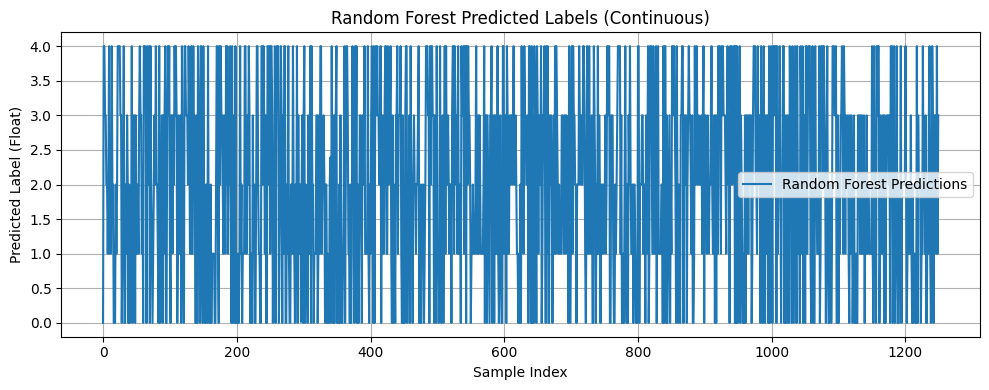

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense

warnings.filterwarnings('ignore')

# === Step 1: Prepare data from df_train ===
X = df_train['Feature_0'].values.reshape(-1, 1)

# Encode string labels to integers
label_encoder = LabelEncoder()
Y_adjusted = label_encoder.fit_transform(df_train['target'])  # e.g., 'New' → 0

# === Step 2: Train Random Forest Regressor ===
rf_regressor = RandomForestRegressor(n_estimators=700, random_state=0)
rf_regressor.fit(X, Y_adjusted)

# Predict using Random Forest
y_pred = rf_regressor.predict(X)

# === Step 3: Define custom accuracy for regression ===
def custom_accuracy(y_true, y_pred):
    threshold = 1.2  # Based on class spacing
    diff = K.abs(y_true - y_pred)
    correct = K.cast(K.less_equal(diff, threshold), K.floatx())
    return K.mean(correct)

# === Step 4: Train Keras regression model on RF predictions ===
model = Sequential([
    Dense(10, input_shape=(1,), activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[custom_accuracy])
model.fit(y_pred.reshape(-1, 1), Y_adjusted, epochs=10, batch_size=16)

# === Step 5: Plot Random Forest predictions ===
plt.figure(figsize=(10, 4))
plt.plot(y_pred, label='Random Forest Predictions')
plt.title('Random Forest Predicted Labels (Continuous)')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Label (Float)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


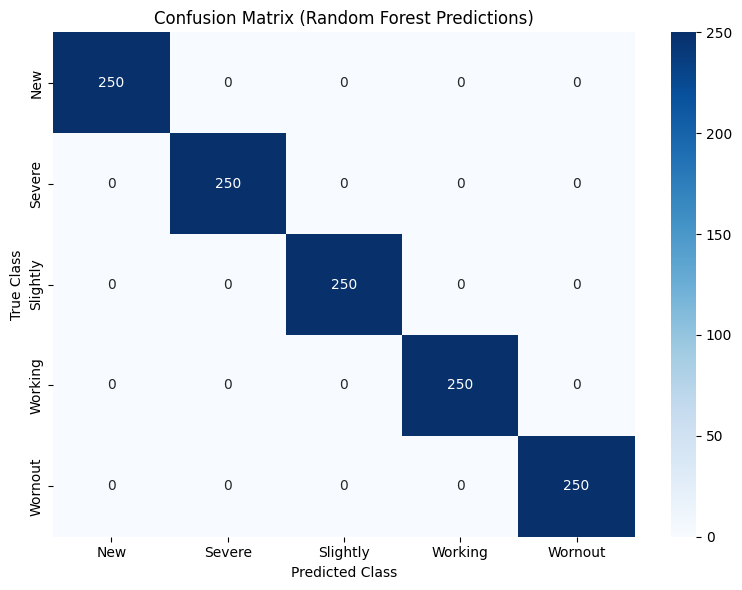

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# === Step 1: Round RF predictions to nearest integer class ===
y_pred_classes = np.round(y_pred).astype(int)

# Ensure predictions are within valid range
y_pred_classes = np.clip(y_pred_classes, 0, len(label_encoder.classes_) - 1)

# === Step 2: Generate confusion matrix ===
cm = confusion_matrix(Y_adjusted, y_pred_classes)
class_names = label_encoder.classes_

# === Step 3: Plot using seaborn heatmap ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Random Forest Predictions)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()


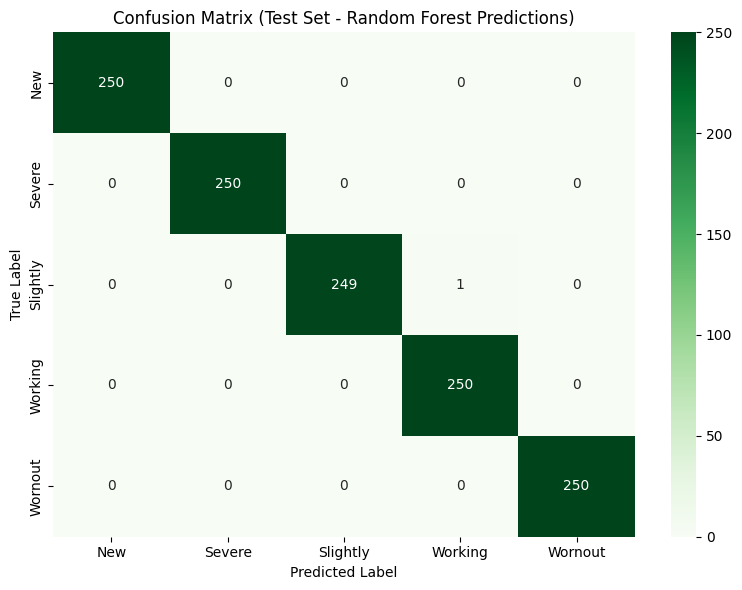

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Step 1: Prepare test data ===
X_test = df_test['Feature_0'].values.reshape(-1, 1)
y_test_str = df_test['target'].values
y_test = label_encoder.transform(y_test_str)  # Encode string labels to integers

# === Step 2: Predict using Random Forest Regressor ===
y_test_pred = rf_regressor.predict(X_test)

# Round to nearest class index and clip to valid range
y_test_pred_classes = np.round(y_test_pred).astype(int)
y_test_pred_classes = np.clip(y_test_pred_classes, 0, len(label_encoder.classes_) - 1)

# === Step 3: Confusion Matrix ===
cm_test = confusion_matrix(y_test, y_test_pred_classes)
class_names = label_encoder.classes_

# === Step 4: Plot Confusion Matrix ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test Set - Random Forest Predictions)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


Epoch 1/10
79/79 [==============================] - 4s 6ms/step - loss: 4.0288 - custom_accuracy: 0.1978 - custom_f1_score: 0.5729 - precision: 1.0000
Epoch 2/10
79/79 [==============================] - 0s 6ms/step - loss: 2.0469 - custom_accuracy: 0.2160 - custom_f1_score: 0.8694 - precision: 1.0000
Epoch 3/10
79/79 [==============================] - 0s 6ms/step - loss: 0.6771 - custom_accuracy: 0.2706 - custom_f1_score: 0.9388 - precision: 1.0000
Epoch 4/10
79/79 [==============================] - 1s 7ms/step - loss: 0.1698 - custom_accuracy: 0.4486 - custom_f1_score: 0.9802 - precision: 1.0000
Epoch 5/10
79/79 [==============================] - 0s 6ms/step - loss: 0.0815 - custom_accuracy: 0.6867 - custom_f1_score: 1.0000 - precision: 1.0000
Epoch 6/10
79/79 [==============================] - 0s 6ms/step - loss: 0.0655 - custom_accuracy: 0.7959 - custom_f1_score: 1.0000 - precision: 1.0000
Epoch 7/10
79/79 [==============================] - 1s 8ms/step - loss: 0.0541 - custom_accura

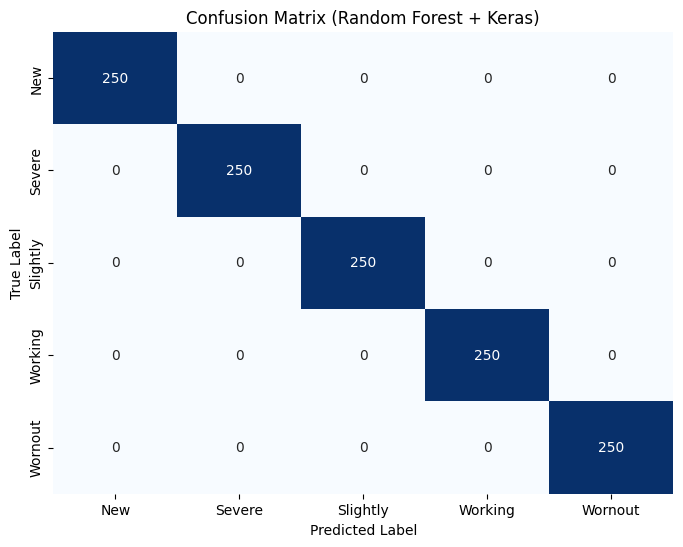

✅ Confusion matrix saved to: C:\Users\Gurukumar\Desktop\ML_output_traintest\Random forest classification1.png


In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import Precision
import keras.backend as K

# === Step 1: Prepare data from df_train ===
X = df_train['Feature_0'].values.reshape(-1, 1)

# Encode string class labels to integers
label_encoder = LabelEncoder()
Y_adjusted = label_encoder.fit_transform(df_train['target'])

# === Step 2: Train Random Forest Regressor ===
rf_regressor = RandomForestRegressor(n_estimators=700, random_state=0)
rf_regressor.fit(X, Y_adjusted)

# Predict using RF
y_pred = rf_regressor.predict(X)

# === Step 3: Define custom metrics ===
def custom_accuracy(y_true, y_pred):
    threshold = 0.3
    diff = K.abs(y_true - y_pred)
    correct = K.cast(K.less_equal(diff, threshold), K.floatx())
    return K.mean(correct)

def custom_f1_score(y_true, y_pred):
    binary_pred = K.round(y_pred)
    true_positives = K.sum(K.round(y_true * binary_pred))
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1_score

# === Step 4: Define and train Keras regression model ===
model = Sequential([
    Dense(10, input_shape=(1,), activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[custom_accuracy, custom_f1_score, Precision()])

model.fit(y_pred.reshape(-1, 1), Y_adjusted, epochs=10, batch_size=16)

# === Step 5: Discretize predictions for confusion matrix ===
bins = np.linspace(0, len(label_encoder.classes_), len(label_encoder.classes_) + 1)
y_pred_discrete = np.digitize(y_pred, bins) - 1  # zero-based class indices

# Clip values to valid range

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(Y_adjusted, y_pred_discrete)

# === Step 7: Plot and Save ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Random Forest + Keras)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# === Step 8: Save plot ===
output_dir = r"C:\Users\Gurukumar\Desktop\ML_output_traintest"
os.makedirs(output_dir, exist_ok=True)

save_path = os.path.join(output_dir, "Random forest classification1.png")
plt.savefig(save_path)
plt.show()

print(f"✅ Confusion matrix saved to: {save_path}")


Number of classes: 5
Class labels: ['New' 'Severe' 'Slightly' 'Working' 'Wornout']
✅ Ensemble Accuracy: 0.9992


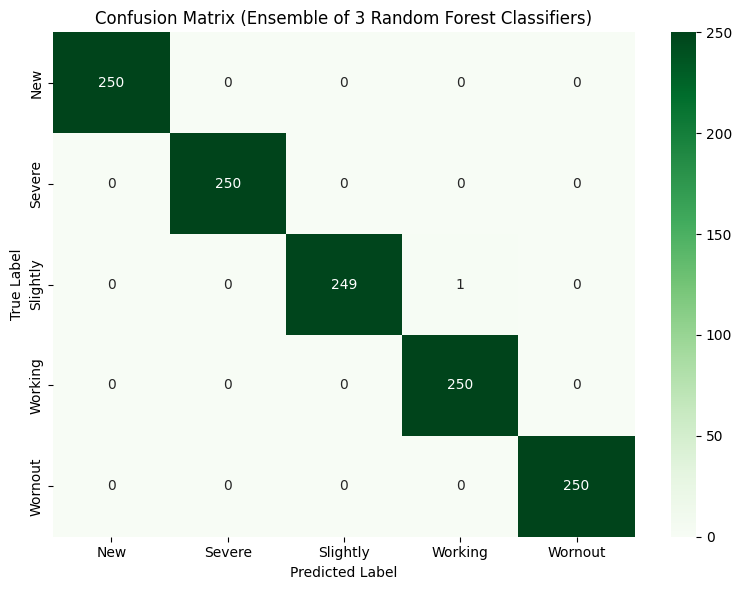

✅ Confusion matrix saved to: C:\Users\Gurukumar\Desktop\ML_output_traintest\Ensemble_RF_confusion_matrix.png


In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode
import os

# === Step 1: Prepare data from df_train and df_test ===
X_train = df_train['Feature_0'].values.reshape(-1, 1)
X_test = df_test['Feature_0'].values.reshape(-1, 1)

# Encode string labels to integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['target'])
y_test = label_encoder.transform(df_test['target'])  # Use same encoder

# Confirm number of classes
print(f"Number of classes: {len(label_encoder.classes_)}")
print("Class labels:", label_encoder.classes_)

# === Step 2: Train 3 Random Forest classifiers ===
tree1 = RandomForestClassifier(n_estimators=200, random_state=42)
tree2 = RandomForestClassifier(n_estimators=200, random_state=52)
tree3 = RandomForestClassifier(n_estimators=200, random_state=62)

tree1.fit(X_train, y_train)
tree2.fit(X_train, y_train)
tree3.fit(X_train, y_train)

# === Step 3: Predict on test data ===
pred1 = tree1.predict(X_test)
pred2 = tree2.predict(X_test)
pred3 = tree3.predict(X_test)

# === Step 4: Majority voting using mode (safe for class indices) ===
all_preds = np.vstack([pred1, pred2, pred3])
ensemble_pred, _ = mode(all_preds, axis=0, keepdims=False)
ensemble_pred = ensemble_pred.flatten()

# Optional safety: Clip in case of unexpected values
ensemble_pred = np.clip(ensemble_pred, 0, len(label_encoder.classes_) - 1)

# === Step 5: Evaluate ===
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print("✅ Ensemble Accuracy:", ensemble_accuracy)

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(y_test, ensemble_pred)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Ensemble of 3 Random Forest Classifiers)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# === Step 7: Save the plot ===
output_dir = r"C:\Users\Gurukumar\Desktop\ML_output_traintest"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "Ensemble_RF_confusion_matrix.png")

plt.savefig(output_path)
plt.show()

print(f"✅ Confusion matrix saved to: {output_path}")


✅ Ensemble Accuracy (SVMs): 0.9952


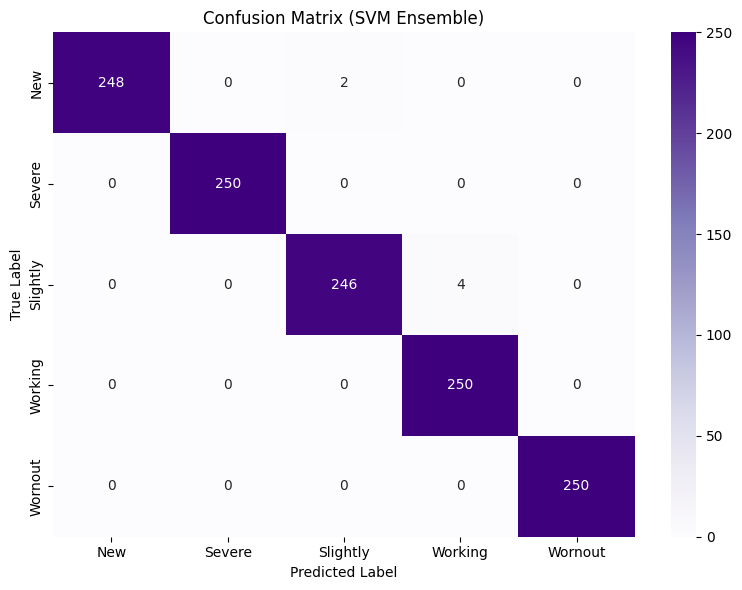

✅ Confusion matrix saved to: C:\Users\Gurukumar\Desktop\ML_output_traintest\SVM_Ensemble_confusion_matrix.png
✅ Cross-Validation Mean Accuracy (Linear SVM): 0.9992000000000001


In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt
import os

# === Step 1: Prepare features and labels from df_train and df_test ===
X_train = df_train['Feature_0'].values.reshape(-1, 1)
X_test = df_test['Feature_0'].values.reshape(-1, 1)

# Encode class labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['target'])
y_test = label_encoder.transform(df_test['target'])  # Use same encoder for test

# === Step 2: Create and train 3 SVM classifiers with different kernels ===
svm1 = SVC(kernel='linear', probability=True, random_state=42)
svm2 = SVC(kernel='rbf', probability=True, random_state=52)
svm3 = SVC(kernel='poly', degree=3, probability=True, random_state=62)

svm1.fit(X_train, y_train)
svm2.fit(X_train, y_train)
svm3.fit(X_train, y_train)

# === Step 3: Predict on test set ===
pred1 = svm1.predict(X_test)
pred2 = svm2.predict(X_test)
pred3 = svm3.predict(X_test)

# === Step 4: Majority voting (safe using mode) ===
all_preds = np.vstack([pred1, pred2, pred3])
ensemble_pred, _ = mode(all_preds, axis=0, keepdims=False)
ensemble_pred = ensemble_pred.flatten()

# === Step 5: Evaluate ensemble ===
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print("✅ Ensemble Accuracy (SVMs):", ensemble_accuracy)

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(y_test, ensemble_pred)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (SVM Ensemble)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Save confusion matrix
output_dir = r"C:\Users\Gurukumar\Desktop\ML_output_traintest"
os.makedirs(output_dir, exist_ok=True)
cm_path = os.path.join(output_dir, "SVM_Ensemble_confusion_matrix.png")
plt.savefig(cm_path)
plt.show()
print(f"✅ Confusion matrix saved to: {cm_path}")

# === Step 7: Cross-validation on full train set (with linear SVM) ===
cv_scores = cross_val_score(SVC(kernel='linear', random_state=42), X_train, y_train, cv=5)
print("✅ Cross-Validation Mean Accuracy (Linear SVM):", np.mean(cv_scores))


✅ Classification Report:

              precision    recall  f1-score   support

         New       1.00      0.99      1.00       250
      Severe       1.00      1.00      1.00       250
    Slightly       0.99      0.98      0.98       250
     Working       0.98      1.00      0.99       250
     Wornout       1.00      1.00      1.00       250

    accuracy                           0.99      1250
   macro avg       0.99      0.99      0.99      1250
weighted avg       0.99      0.99      0.99      1250



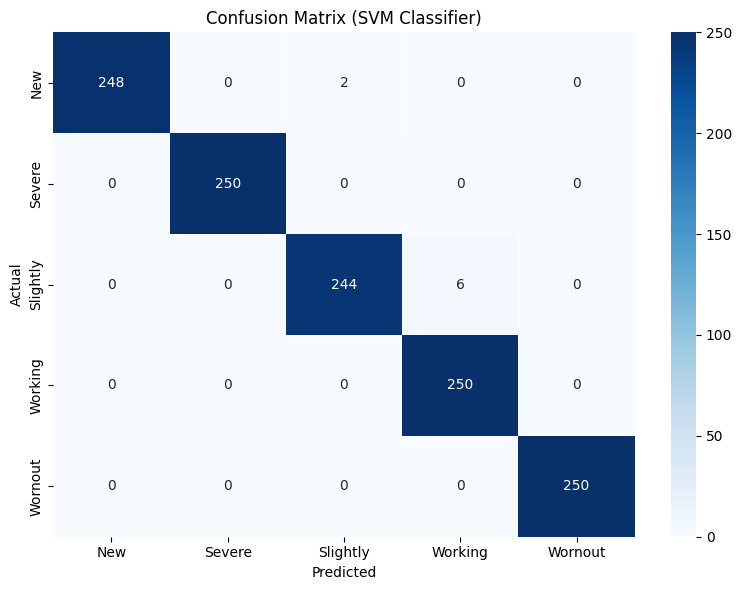

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# === Step 1: Decode byte labels (just once globally)
df_train['target'] = df_train['target'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
df_test['target'] = df_test['target'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# === Step 2: Feature and Label preparation ===
X_train = df_train['Feature_0'].values.reshape(-1, 1)
X_test = df_test['Feature_0'].values.reshape(-1, 1)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['target'])
y_test = label_encoder.transform(df_test['target'])

# === Step 3: Train SVM ===
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# === Step 4: Predict and evaluate ===
y_pred = svm_model.predict(X_test)

# Classification Report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("✅ Classification Report:\n")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (SVM Classifier)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()

# Save the confusion matrix plot
output_path = r"C:\Users\Gurukumar\Desktop\ML_output_traintest"
os.makedirs(output_path, exist_ok=True)
plt.savefig(os.path.join(output_path, "SVM_Confusion_Matrix.png"))
plt.show()


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def compute_stats_df(df, feature_col='Feature_0', target_col='target', num_chunks=25):
    # Ensure input DataFrame has required columns
    df = df[[feature_col, target_col]].copy()
    
    # Ensure labels are string
    df[target_col] = df[target_col].astype(str)
    
    # One DataFrame per class
    class_groups = df.groupby(target_col)
    
    # Lists to store statistics and labels
    stats_summary = []
    labels = []
    
    # For each class, chunk its data into num_chunks parts and compute stats
    for label, group in class_groups:
        feature_series = group[feature_col].reset_index(drop=True)
        chunk_size = int(np.ceil(len(feature_series) / num_chunks))
        
        # Ensure exactly num_chunks are generated
        for i in range(num_chunks):
            start = i * chunk_size
            end = min((i + 1) * chunk_size, len(feature_series))
            subset = feature_series[start:end]
            if not subset.empty:
                stats_summary.append({
                    'mean': subset.mean(),
                    'median': subset.median(),
                    'mode': subset.mode().iloc[0] if not subset.mode().empty else subset.iloc[0],
                    'variance': subset.var(),
                    'std': subset.std(),
                    '1st_quartile': subset.quantile(0.25),
                    '3rd_quartile': subset.quantile(0.75),
                    'iqr': subset.quantile(0.75) - subset.quantile(0.25),
                    'skew': subset.skew(),
                    'kurt': subset.kurt(),
                    'max': subset.max(),
                    'min': subset.min(),
                    'range': subset.max() - subset.min()
                })
                labels.append(label)
            else:
                # If insufficient data, pad with the last valid stats
                if stats_summary:  # Only pad if we have previous stats
                    last_stats = stats_summary[-1].copy()
                    stats_summary.append(last_stats)
                    labels.append(label)
    
    # Create stats DataFrame and labels Series
    stats_df = pd.DataFrame(stats_summary)
    Y_adjusted = pd.Series(labels)
    
    # Convert categorical labels to numeric
    le = LabelEncoder()
    Y_encoded = le.fit_transform(Y_adjusted)
    
    return stats_df, Y_encoded, le

# Process training data with 25 chunks per class
train_stats_df, train_Y_encoded, train_le = compute_stats_df(df_train, num_chunks=25)

# Process test data with 25 chunks per class to ensure 25 samples per class
test_stats_df, test_Y_encoded, test_le = compute_stats_df(df_test, num_chunks=25)

In [19]:
train_stats_df

,mean,median,mode,variance,std,1st_quartile,3rd_quartile,iqr,skew,kurt,max,min,range
0,11.184046,11.064465,10.021821,1.070427,1.034614,10.304410,11.803947,1.499536,0.647162,-0.114527,13.198190,10.021821,3.176369
1,10.688290,10.620850,10.080172,0.237552,0.487393,10.287111,11.019206,0.732095,0.506587,-0.808210,11.554647,10.080172,1.474476
2,10.919374,10.768410,10.034165,0.601198,0.775370,10.291132,11.347054,1.055922,0.596711,-0.939535,12.255977,10.034165,2.221812
3,10.646659,10.615053,10.064462,0.213771,0.462354,10.399978,10.858835,0.458857,0.780259,1.098727,11.617861,10.064462,1.553399
4,11.000803,10.806749,10.366688,0.495947,0.704235,10.520513,11.231475,0.710961,1.917456,4.502788,12.759812,10.366688,2.393124
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,71.698475,66.134181,60.774152,124.001767,11.135608,63.474832,80.679478,17.204646,0.792850,-1.200738,89.040918,60.774152,28.266766
121,65.522247,63.733389,60.280790,28.111830,5.302059,61.643146,69.434077,7.790931,0.762784,-0.997661,74.636915,60.280790,14.356125
122,68.798448,66.973906,60.238149,100.085587,10.004278,60.428350,71.108946,10.680597,1.164036,0.427114,88.708020,60.238149,28.469871
123,66.143121,64.561145,60.399735,29.712779,5.450943,61.496054,70.767632,9.271578,0.581438,-1.351736,74.254644,60.399735,13.854908


In [20]:
test_stats_df

,mean,median,mode,variance,std,1st_quartile,3rd_quartile,iqr,skew,kurt,max,min,range
0,10.641498,10.561191,10.053615,0.292693,0.541011,10.266913,10.662276,0.395363,1.152787,0.314703,11.623097,10.053615,1.569482
1,10.719149,10.458142,10.156477,0.578776,0.760773,10.244283,10.582324,0.338041,1.806553,2.423366,12.451227,10.156477,2.294751
2,10.582324,10.393620,10.003867,0.231278,0.480913,10.210993,10.943556,0.732562,0.526953,-1.353603,11.377725,10.003867,1.373858
3,10.724385,10.638430,10.031172,0.381692,0.617812,10.196125,11.189769,0.993644,0.245695,-1.877138,11.614120,10.031172,1.582948
4,10.916830,10.902130,10.080546,0.505820,0.711210,10.278227,11.359210,1.080983,0.515709,-0.383459,12.261214,10.080546,2.180668
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,66.348732,64.603599,61.380101,22.491732,4.742545,63.033462,68.178978,5.145516,1.154598,0.661748,76.216871,61.380101,14.836770
121,70.142121,69.911636,60.677275,68.268161,8.262455,62.622296,74.203400,11.581104,0.473782,-0.663605,84.980312,60.677275,24.303037
122,64.260415,63.625291,60.117333,16.725517,4.089684,61.298279,64.916205,3.617926,1.215114,1.152116,73.033769,60.117333,12.916436
123,67.181911,63.028319,60.212714,83.089403,9.115339,60.897773,69.167666,8.269893,1.646673,2.309368,88.118155,60.212714,27.905441


Training data shape: (125, 13)
Test data shape: (125, 13)
Training target shape: (125,)
Test target shape: (125,)


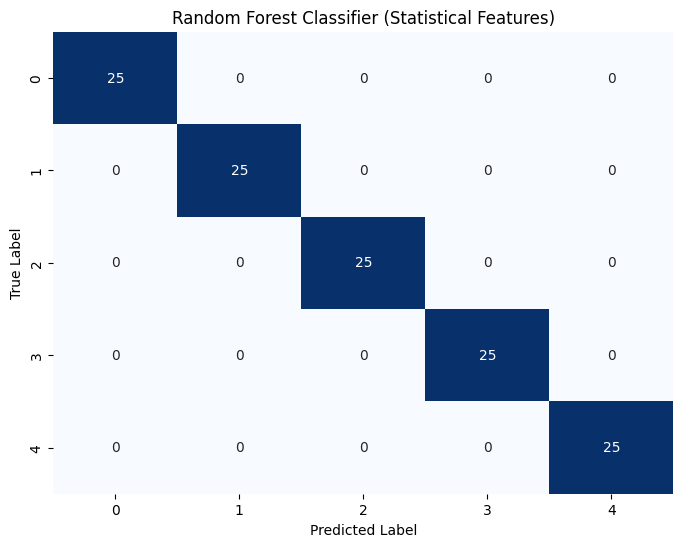

Confusion Matrix saved to: C:\Users\Gurukumar\Desktop\ML_output_traintest\RandomForest_Classifier_CM.png
Standard Accuracy: 1.00
Custom Accuracy (±1 tolerance): 1.00
Neural network trained on RF outputs.
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        25

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



In [21]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K

# === Step 1: Prepare Data ===
# Assuming train_stats_df, test_stats_df, train_Y_encoded, test_Y_encoded are already generated
X_train = train_stats_df
X_test = test_stats_df
y_train = train_Y_encoded
y_test = test_Y_encoded

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)

# === Step 2: Random Forest Classifier ===
rf_classifier = RandomForestClassifier(
    n_estimators=700,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42
)
rf_classifier.fit(X_train, y_train)
y_pred_discrete = rf_classifier.predict(X_test)

# === Step 3: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_discrete)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Random Forest Classifier (Statistical Features)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Save the confusion matrix plot
output_dir = r"C:\Users\Gurukumar\Desktop\ML_output_traintest"
os.makedirs(output_dir, exist_ok=True)
save_path = os.path.join(output_dir, "RandomForest_Classifier_CM.png")
plt.savefig(save_path)
plt.show()

print(f"Confusion Matrix saved to: {save_path}")

# === Step 4: Accuracy Metrics ===
accuracy = accuracy_score(y_test, y_pred_discrete)
print(f"Standard Accuracy: {accuracy:.2f}")

def custom_accuracy(y_true, y_pred, threshold=1):
    return np.mean(np.abs(y_true - y_pred) <= threshold)

custom_acc = custom_accuracy(y_test, y_pred_discrete)
print(f"Custom Accuracy (±1 tolerance): {custom_acc:.2f}")

# === Step 5: Train Neural Network on RF predictions ===
model = Sequential([
    Dense(10, input_shape=(1,), activation='relu'),
    Dense(1)
])

def custom_accuracy_metric(y_true, y_pred):
    return K.mean(K.less_equal(K.abs(y_true - y_pred), 1.0))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[custom_accuracy_metric])

model.fit(y_pred_discrete.reshape(-1, 1), y_test, epochs=10, verbose=0)
print("Neural network trained on RF outputs.")

# === Step 6: Classification Report ===
report = classification_report(y_test, y_pred_discrete)
print("Classification Report:\n", report)

In [35]:
print("Keys:", stats_df.keys())
print("Number of elements in each list:")
for key, value in stats_df.items():
    print(key, ":", len(value))

Keys: Index(['mean', 'median', 'mode', 'variance', 'std', '1st quartile',
       '3rd quartile', 'iqr', 'skew', 'kurt', 'max', 'min', 'range'],
      dtype='object')
Number of elements in each list:
mean : 250
median : 250
mode : 250
variance : 250
std : 250
1st quartile : 250
3rd quartile : 250
iqr : 250
skew : 250
kurt : 250
max : 250
min : 250
range : 250


✅ Training data shape: (125, 13)
✅ Test data shape: (125, 13)
✅ Training target shape: (125,)
✅ Test target shape: (125,)


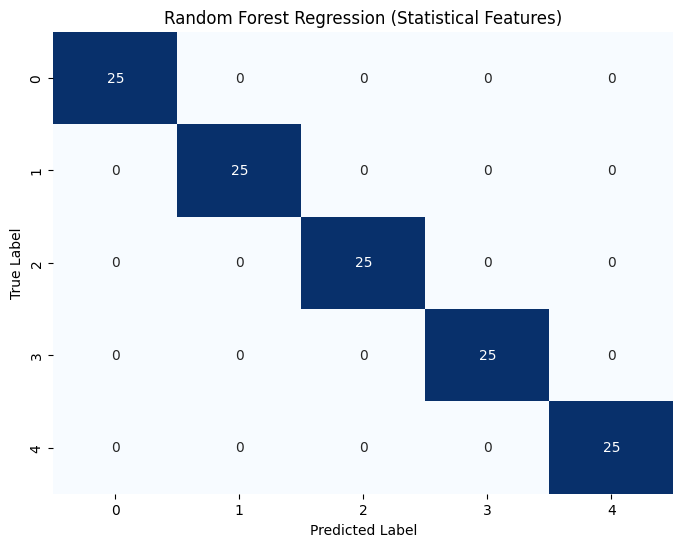

✅ Confusion Matrix saved to: C:\Users\Gurukumar\Desktop\ML_output_traintest\Random_forest_statistics.png
🎯 Standard Accuracy: 1.00
🎯 Custom Accuracy (±1 tolerance): 1.00
🤖 Neural network trained on RF outputs.

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        25

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



In [22]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
import os

# === Step 1: Setup Data ===
# Assuming train_stats_df, test_stats_df, train_Y_encoded, test_Y_encoded are already generated
X_train = train_stats_df
X_test = test_stats_df
Y_train = train_Y_encoded
Y_test = test_Y_encoded

print("✅ Training data shape:", X_train.shape)
print("✅ Test data shape:", X_test.shape)
print("✅ Training target shape:", Y_train.shape)
print("✅ Test target shape:", Y_test.shape)

# === Step 2: Train Random Forest Regressor ===
rf_regressor = RandomForestRegressor(n_estimators=700, random_state=42)
rf_regressor.fit(X_train, Y_train)

# === Step 3: Predict and Discretize ===
y_pred = rf_regressor.predict(X_test)

# Create bins to discretize continuous predictions
num_classes = 5
bins = np.linspace(min(Y_test) - 0.5, max(Y_test) + 0.5, num_classes + 1)
y_pred_discrete = np.digitize(y_pred, bins) - 1
y_pred_discrete = np.clip(y_pred_discrete, 0, num_classes - 1)

# === Step 4: Confusion Matrix ===
cm = confusion_matrix(Y_test, y_pred_discrete)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Random Forest Regression (Statistical Features)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Save confusion matrix plot
save_path = r"C:\Users\Gurukumar\Desktop\ML_output_traintest\Random_forest_statistics.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()
print(f"✅ Confusion Matrix saved to: {save_path}")

# === Step 5: Accuracy Metrics ===
accuracy = accuracy_score(Y_test, y_pred_discrete)
print(f"🎯 Standard Accuracy: {accuracy:.2f}")

def custom_accuracy(y_true, y_pred, threshold=1):
    return np.mean(np.abs(y_true - y_pred) <= threshold)

custom_acc = custom_accuracy(Y_test, y_pred_discrete)
print(f"🎯 Custom Accuracy (±1 tolerance): {custom_acc:.2f}")

# === Step 6: Train Neural Network on RF outputs ===
model = Sequential([
    Dense(10, input_shape=(1,), activation='relu'),
    Dense(1)
])

# Define custom accuracy metric for Keras
def custom_accuracy_metric(y_true, y_pred):
    return K.mean(K.less_equal(K.abs(y_true - y_pred), 1.0))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[custom_accuracy_metric])
model.fit(y_pred.reshape(-1, 1), Y_test, epochs=10, verbose=0)
print("🤖 Neural network trained on RF outputs.")

# === Step 7: Classification Report ===
report = classification_report(Y_test, y_pred_discrete)
print("\n📋 Classification Report:\n", report)


Training Principal Components:
          PC1       PC2
0   -2.723654 -0.644346
1   -2.983243 -0.929419
2   -2.872362 -0.904237
3   -2.944266 -0.079208
4   -2.649883  2.024338
..        ...       ...
120  7.760360 -2.207827
121  4.483652 -1.280801
122  6.713556 -0.842715
123  4.633680 -1.672877
124  6.020234  2.896465

[125 rows x 2 columns]

Test Principal Components:
          PC1       PC2
0   -2.923640  0.060463
1   -2.761269  1.327873
2   -3.007523 -1.070071
3   -2.987412 -1.520765
4   -2.873503 -0.821185
..        ...       ...
120  4.321757 -0.202359
121  6.189580 -1.829328
122  3.821466  0.122695
123  6.213106  0.400607
124  5.504172 -1.925293

[125 rows x 2 columns]

Classification Report:
Accuracy: 0.992


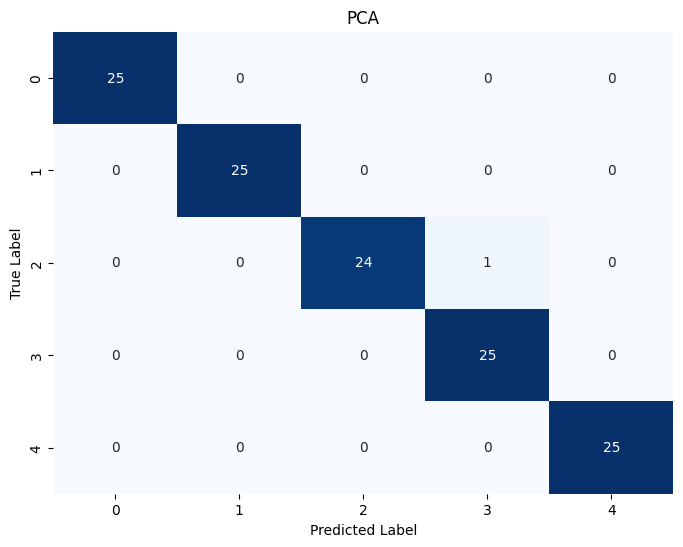

In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Assuming train_stats_df, test_stats_df, train_Y_encoded, test_Y_encoded are already generated
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_stats_df)
X_test_scaled = scaler.transform(test_stats_df)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Create DataFrames for principal components
train_principal_df = pd.DataFrame(data=X_train_pca, columns=['PC1', 'PC2'])
test_principal_df = pd.DataFrame(data=X_test_pca, columns=['PC1', 'PC2'])
print("\nTraining Principal Components:")
print(train_principal_df)
print("\nTest Principal Components:")
print(test_principal_df)

# Use pre-generated target variables
y_train = train_Y_encoded
y_test = test_Y_encoded

# Choose a machine learning model (Logistic Regression)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)

# Train the model on the training data
model.fit(train_principal_df, y_train)

# Make predictions on the testing data
y_pred = model.predict(test_principal_df)

# Evaluate the model
print("\nClassification Report:")
print("Accuracy:", accuracy_score(y_test, y_pred))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("PCA")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
save_path = r"C:\Users\Gurukumar\Desktop\ML_output_traintest\PCA_regression.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()

✅ Training data shape: (125, 13)
✅ Test data shape: (125, 13)
✅ Training target shape: (125,)
✅ Test target shape: (125,)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Ensemble Accuracy (Grid Search): 1.0
Cross-Validation Mean Accuracy (Grid Search): 1.0


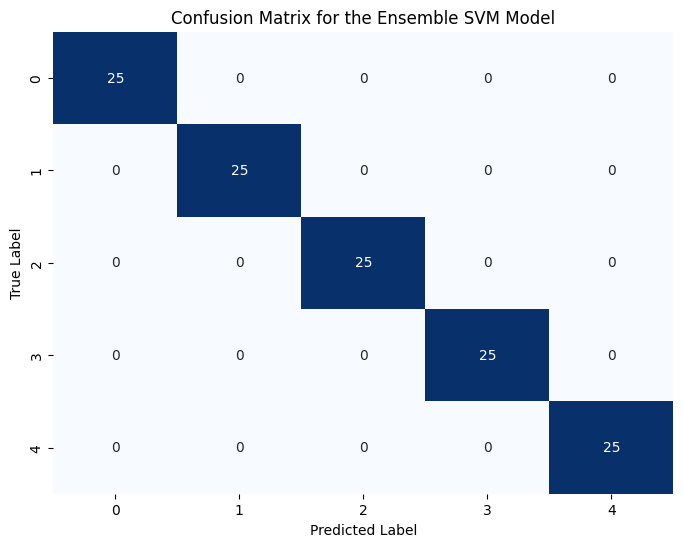


📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        25

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Assuming train_stats_df, test_stats_df, train_Y_encoded, test_Y_encoded are already generated
X_train = train_stats_df
X_test = test_stats_df
y_train = train_Y_encoded
y_test = test_Y_encoded

print("✅ Training data shape:", X_train.shape)
print("✅ Test data shape:", X_test.shape)
print("✅ Training target shape:", y_train.shape)
print("✅ Test target shape:", y_test.shape)

# Define the parameter grid for each SVM classifier
param_grid_linear = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear']
}

param_grid_rbf = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

param_grid_poly = {
    'C': [0.1, 1, 10, 100],
    'degree': [2, 3, 4],
    'kernel': ['poly']
}

# Perform Grid Search for each SVM classifier
grid_search_linear = GridSearchCV(SVC(), param_grid_linear, cv=5, n_jobs=-1, verbose=2)
grid_search_rbf = GridSearchCV(SVC(), param_grid_rbf, cv=5, n_jobs=-1, verbose=2)
grid_search_poly = GridSearchCV(SVC(), param_grid_poly, cv=5, n_jobs=-1, verbose=2)

# Fit Grid Search
grid_search_linear.fit(X_train, y_train)
grid_search_rbf.fit(X_train, y_train)
grid_search_poly.fit(X_train, y_train)

# Get the best models
best_svm1 = grid_search_linear.best_estimator_
best_svm2 = grid_search_rbf.best_estimator_
best_svm3 = grid_search_poly.best_estimator_

# Train and make predictions using the best models
best_svm1.fit(X_train, y_train)
best_svm2.fit(X_train, y_train)
best_svm3.fit(X_train, y_train)

pred1 = best_svm1.predict(X_test)
pred2 = best_svm2.predict(X_test)
pred3 = best_svm3.predict(X_test)

# Compute ensemble predictions (majority voting approximated by averaging and rounding)
ensemble_pred = (pred1 + pred2 + pred3) // 3
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print("Ensemble Accuracy (Grid Search):", ensemble_accuracy)

# Cross-validation scores for the best linear SVM
cv_scores = cross_val_score(best_svm1, X_train, y_train, cv=5)
print("Cross-Validation Mean Accuracy (Grid Search):", np.mean(cv_scores))

# Calculate the ensemble confusion matrix
conf_matrix_ensemble = confusion_matrix(y_test, ensemble_pred)
report = classification_report(y_test, ensemble_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for the Ensemble SVM Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
save_path = r"C:\Users\Gurukumar\Desktop\ML_output_traintest\SVM_ensemble.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()

print("\n📋 Classification Report:\n", report)

In [25]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Assuming train_stats_df, test_stats_df, train_Y_encoded, test_Y_encoded are already generated
X_train = train_stats_df
X_test = test_stats_df
y_train = train_Y_encoded
y_test = test_Y_encoded

print("✅ Training data shape:", X_train.shape)
print("✅ Test data shape:", X_test.shape)
print("✅ Training target shape:", y_train.shape)
print("✅ Test target shape:", y_test.shape)

# Define the SVM model
svm_model = SVC()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],              # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Different kernel functions
    'gamma': ['scale', 'auto']            # Kernel coefficient
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(svm_model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Use the best estimator to predict on the test data
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test)

# Generate and print the classification report
report = classification_report(y_test, y_pred)
print("Best Hyperparameters:", grid_search.best_params_)
print("Classification Report:\n", report)

✅ Training data shape: (125, 13)
✅ Test data shape: (125, 13)
✅ Training target shape: (125,)
✅ Test target shape: (125,)
Best Hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        25

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



✅ Training data shape: (125, 13)
✅ Test data shape: (125, 13)
✅ Training target shape: (125,)
✅ Test target shape: (125,)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Ensemble Accuracy (Grid Search): 1.0
Cross-Validation Mean Accuracy (Grid Search): 1.0


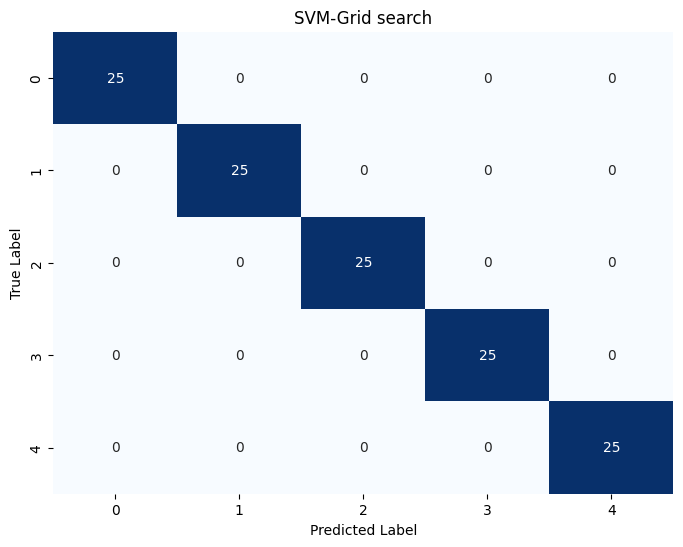


📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        25

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import os

# Assuming train_stats_df, test_stats_df, train_Y_encoded, test_Y_encoded are already generated
X_train = train_stats_df
X_test = test_stats_df
y_train = train_Y_encoded
y_test = test_Y_encoded

print("✅ Training data shape:", X_train.shape)
print("✅ Test data shape:", X_test.shape)
print("✅ Training target shape:", y_train.shape)
print("✅ Test target shape:", y_test.shape)

# Define the parameter grid for each SVM classifier
param_grid_linear = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear']
}

param_grid_rbf = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

param_grid_poly = {
    'C': [0.1, 1, 10, 100],
    'degree': [2, 3, 4],
    'kernel': ['poly']
}

# Perform Grid Search for each SVM classifier
grid_search_linear = GridSearchCV(SVC(), param_grid_linear, cv=5, n_jobs=-1, verbose=2)
grid_search_rbf = GridSearchCV(SVC(), param_grid_rbf, cv=5, n_jobs=-1, verbose=2)
grid_search_poly = GridSearchCV(SVC(), param_grid_poly, cv=5, n_jobs=-1, verbose=2)

# Fit Grid Search on the training data
grid_search_linear.fit(X_train, y_train)
grid_search_rbf.fit(X_train, y_train)
grid_search_poly.fit(X_train, y_train)

# Get the best models
best_svm1 = grid_search_linear.best_estimator_
best_svm2 = grid_search_rbf.best_estimator_
best_svm3 = grid_search_poly.best_estimator_

# Make predictions using the best models on the test set
pred1 = best_svm1.predict(X_test)
pred2 = best_svm2.predict(X_test)
pred3 = best_svm3.predict(X_test)

# Ensemble predictions by averaging the predicted classes
ensemble_pred = (pred1 + pred2 + pred3) // 3

# Calculate the ensemble accuracy
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print("Ensemble Accuracy (Grid Search):", ensemble_accuracy)

# Perform cross-validation on the best SVM model
cv_scores = cross_val_score(best_svm1, X_train, y_train, cv=5)
print("Cross-Validation Mean Accuracy (Grid Search):", np.mean(cv_scores))

# Calculate the ensemble confusion matrix
conf_matrix_ensemble = confusion_matrix(y_test, ensemble_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("SVM-Grid search")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Save the confusion matrix plot
save_path = r"C:\Users\Gurukumar\Desktop\ML_output_traintest\SVM_grid_search.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()

# Generate and print the classification report
report = classification_report(y_test, ensemble_pred)
print("\n📋 Classification Report:\n", report)

In [29]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report

# Assuming train_stats_df, test_stats_df, train_Y_encoded, test_Y_encoded are already generated
# Drop the 'min' column from the features
X_train = train_stats_df.drop('min', axis=1)
X_test = test_stats_df.drop('min', axis=1)
y_train = train_Y_encoded
y_test = test_Y_encoded

print("✅ Training data shape:", X_train.shape)
print("✅ Test data shape:", X_test.shape)
print("✅ Training target shape:", y_train.shape)
print("✅ Test target shape:", y_test.shape)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Choose an SVM model (SVR for regression)
svm_model = SVR(kernel='rbf')

# Train the SVM model on the training data
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred = svm_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate R^2 score
r2 = r2_score(y_test, y_pred)
print("R-squared (R^2) Score:", r2)

# Convert predictions to the nearest integer class for classification metrics
y_pred_class = np.round(y_pred).astype(int)
y_test_class = y_test.astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_class, y_pred_class)
print("Accuracy:", accuracy)

# Generate and print the classification report
report = classification_report(y_test_class, y_pred_class)
print("\n📋 Classification Report:\n", report)

✅ Training data shape: (125, 12)
✅ Test data shape: (125, 12)
✅ Training target shape: (125,)
✅ Test target shape: (125,)
Mean Squared Error: 0.18376245524082274
R-squared (R^2) Score: 0.9081187723795886
Accuracy: 0.768

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.04      0.08        25
           1       0.51      1.00      0.68        25
           2       0.93      1.00      0.96        25
           3       0.89      0.96      0.92        25
           4       1.00      0.84      0.91        25

    accuracy                           0.77       125
   macro avg       0.87      0.77      0.71       125
weighted avg       0.87      0.77      0.71       125



In [30]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assuming train_stats_df, test_stats_df, train_Y_encoded, test_Y_encoded are already generated
X_train = train_stats_df
X_test = test_stats_df
y_train = train_Y_encoded
y_test = test_Y_encoded

print("✅ Training data shape:", X_train.shape)
print("✅ Test data shape:", X_test.shape)
print("✅ Training target shape:", y_train.shape)
print("✅ Test target shape:", y_test.shape)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform PCA retaining 95% of the variance
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Create DataFrames for principal components
train_principal_df = pd.DataFrame(data=X_train_pca)
test_principal_df = pd.DataFrame(data=X_test_pca)
print("\nTraining Principal Components:")
print(train_principal_df)
print("\nTest Principal Components:")
print(test_principal_df)

# Choose a machine learning model (Logistic Regression)
model = LogisticRegression()

# Train the model on the training data
model.fit(train_principal_df, y_train)

# Make predictions on the testing data
y_pred = model.predict(test_principal_df)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

✅ Training data shape: (125, 13)
✅ Test data shape: (125, 13)
✅ Training target shape: (125,)
✅ Test target shape: (125,)

Training Principal Components:
            0         1         2
0   -2.723654 -0.644346  0.616822
1   -2.983243 -0.929419  0.385587
2   -2.872362 -0.904237  0.491038
3   -2.944266 -0.079208  0.437738
4   -2.649883  2.024338  0.740564
..        ...       ...       ...
120  7.760360 -2.207827  2.635523
121  4.483652 -1.280801 -1.104310
122  6.713556 -0.842715  1.743437
123  4.633680 -1.672877 -1.019359
124  6.020234  2.896465  0.677313

[125 rows x 3 columns]

Test Principal Components:
            0         1         2
0   -2.923640  0.060463  0.496016
1   -2.761269  1.327873  0.688240
2   -3.007523 -1.070071  0.382867
3   -2.987412 -1.520765  0.372373
4   -2.873503 -0.821185  0.474308
..        ...       ...       ...
120  4.321757 -0.202359 -1.446056
121  6.189580 -1.829328  0.550023
122  3.821466  0.122695 -1.704744
123  6.213106  0.400607  1.253224
124  5.50417

✅ Training data shape: (125, 13)
✅ Test data shape: (125, 13)
✅ Training target shape: (125,)
✅ Test target shape: (125,)

Training Principal Components:
          0         1         2
0 -2.723654 -0.644346  0.616822
1 -2.983243 -0.929419  0.385587
2 -2.872362 -0.904237  0.491038
3 -2.944266 -0.079208  0.437738
4 -2.649883  2.024338  0.740564

Test Principal Components:
          0         1         2
0 -2.923640  0.060463  0.496016
1 -2.761269  1.327873  0.688240
2 -3.007523 -1.070071  0.382867
3 -2.987412 -1.520765  0.372373
4 -2.873503 -0.821185  0.474308

Training Set Class Distribution:
0    25
1    25
2    25
3    25
4    25
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        25
           4       1.00      1.00      

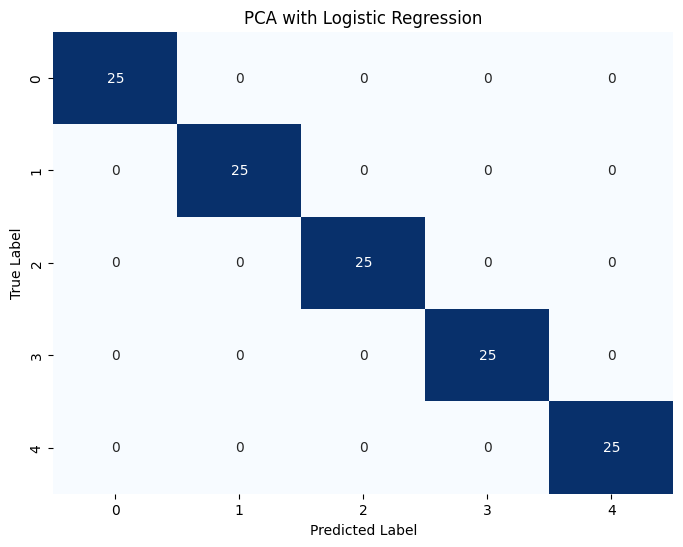

In [31]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Assuming train_stats_df, test_stats_df, train_Y_encoded, test_Y_encoded are already generated
X_train = train_stats_df
X_test = test_stats_df
y_train = train_Y_encoded
y_test = test_Y_encoded

print("✅ Training data shape:", X_train.shape)
print("✅ Test data shape:", X_test.shape)
print("✅ Training target shape:", y_train.shape)
print("✅ Test target shape:", y_test.shape)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform PCA retaining 95% of the variance
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Create DataFrames for principal components
train_principal_df = pd.DataFrame(data=X_train_pca)
test_principal_df = pd.DataFrame(data=X_test_pca)
print("\nTraining Principal Components:")
print(train_principal_df.head())
print("\nTest Principal Components:")
print(test_principal_df.head())

# Check the distribution in the training set to ensure no data leakage or imbalance
print("\nTraining Set Class Distribution:")
print(pd.Series(y_train).value_counts())

# Define a logistic regression model for multi-class classification
model = LogisticRegression(multi_class='multinomial', max_iter=300, solver='saga')

# Define hyperparameters grid for tuning
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['saga'],  # Using 'saga' solver as it supports multi-class with l1, l2 penalties
    'max_iter': [300]  # Setting max_iter to a high value to ensure convergence
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_principal_df, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the testing data using the best model
y_pred = best_model.predict(test_principal_df)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Confusion matrix to see where predictions are failing
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("PCA with Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
save_path = r"C:\Users\Gurukumar\Desktop\ML_output_traintest\PCA_grid_search.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()

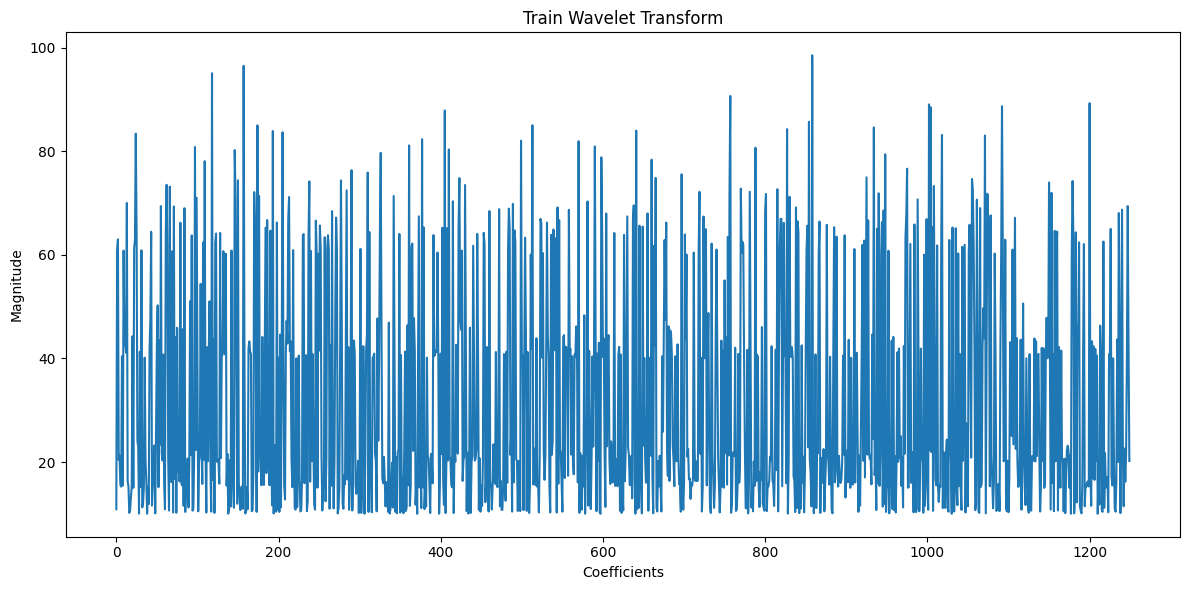

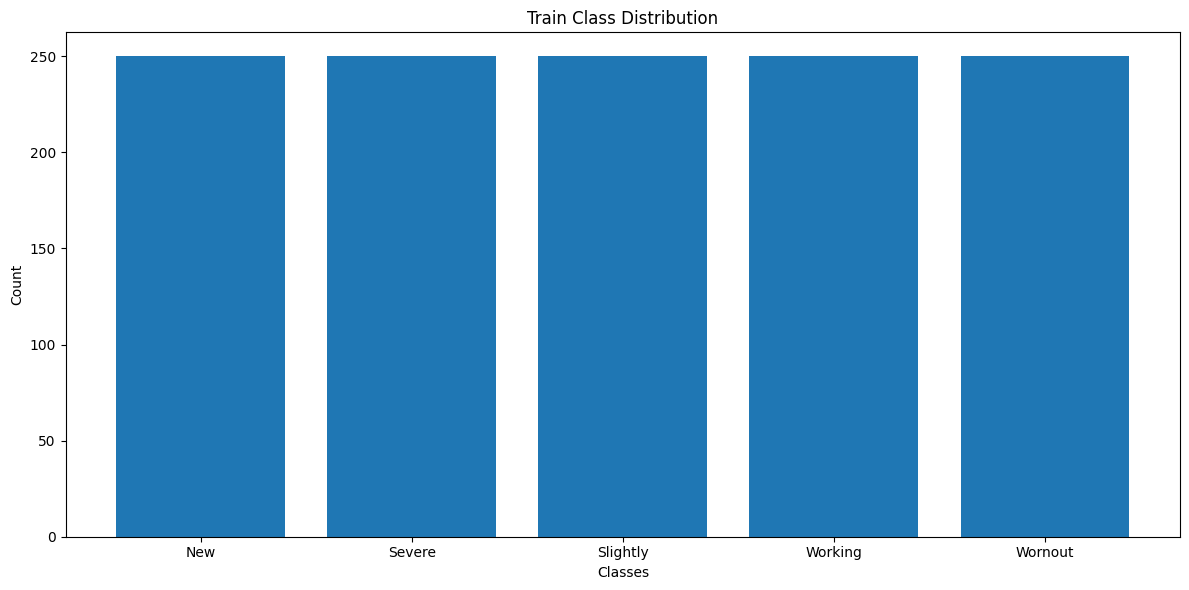

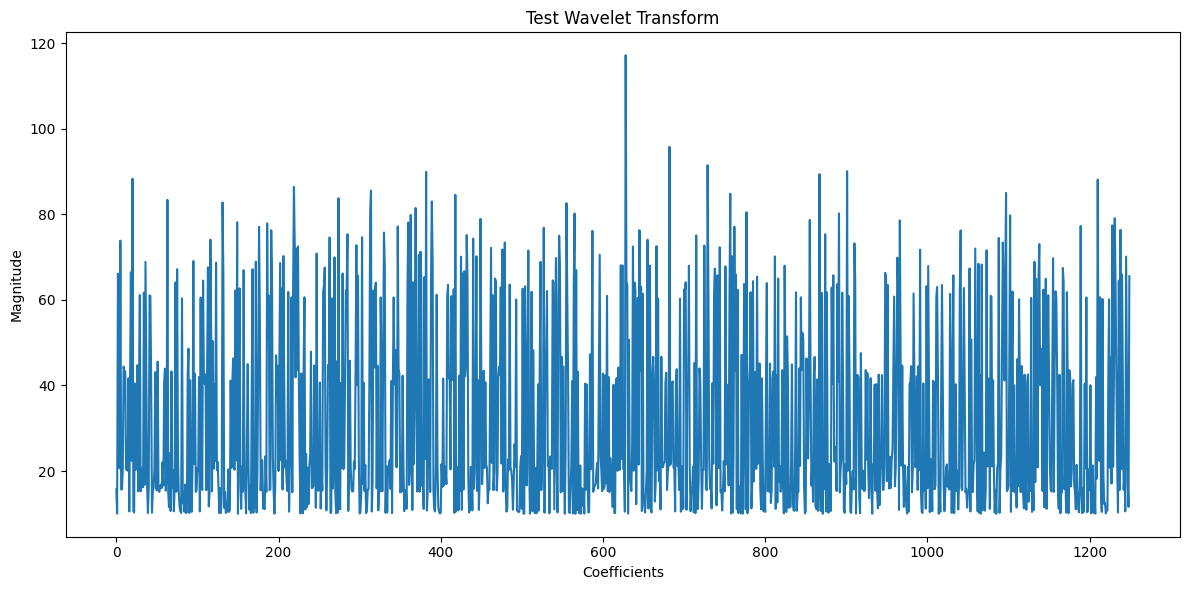

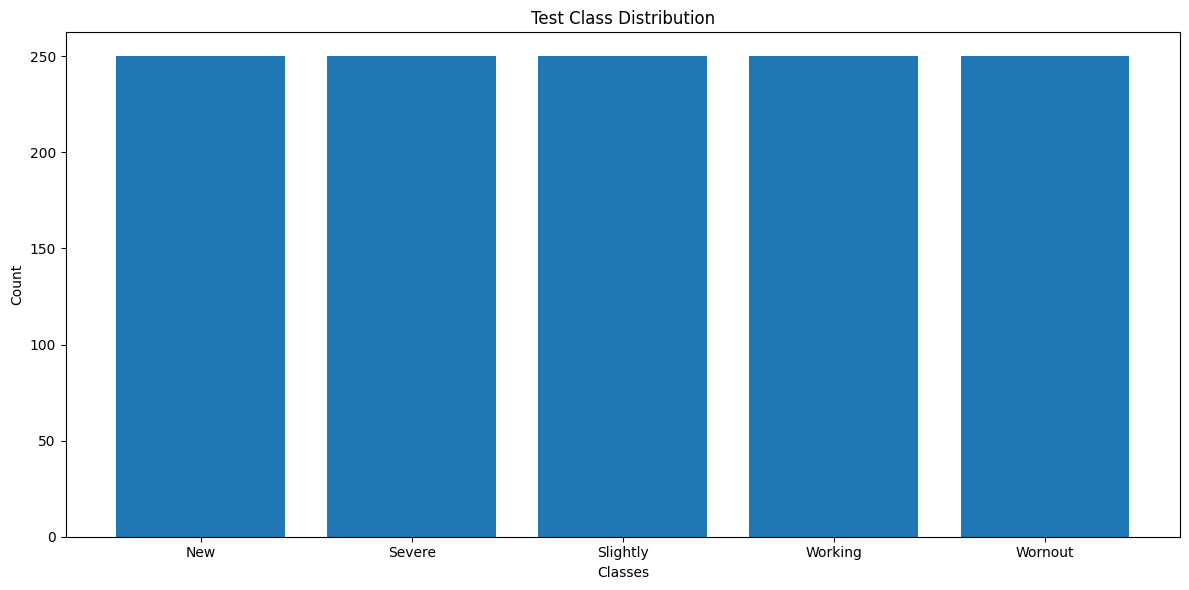

In [54]:
import numpy as np
import h5py
import pywt
import matplotlib.pyplot as plt

# === Wavelet Transform ===
def flat_wavelet_transform2(data, method):
    """For a 1D or 2D data, apply wavelet transform and flatten output."""
    if data.ndim == 1:
        data = data.reshape(1, -1)
    coeffs = pywt.wavedec2(data, method)
    output = coeffs[0].reshape(-1)
    for tups in coeffs[1:]:
        for c in tups:
            output = np.concatenate((output, c.reshape(-1)))
    return output

# === Plot Wavelet Output and Class Distribution ===
def plot_wavelet_transform(transformed_data, classes, title_prefix=""):
    plt.figure(figsize=(12, 6))
    plt.plot(transformed_data)
    plt.title(f'{title_prefix} Wavelet Transform')
    plt.xlabel('Coefficients')
    plt.ylabel('Magnitude')
    plt.tight_layout()
    plt.show()

    # Convert byte labels if necessary
    if isinstance(classes[0], bytes):
        classes = [c.decode('utf-8') for c in classes]

    plt.figure(figsize=(12, 6))
    unique, counts = np.unique(classes, return_counts=True)
    indices = np.arange(len(unique))
    plt.bar(indices, counts)
    plt.xticks(indices, unique)
    plt.title(f'{title_prefix} Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# === Settings ===
wavelet_method = 'haar'  # You can replace with any from methods[]

# === Load & Process TRAIN Data ===
train_path = r"C:\Users\Gurukumar\Desktop\train_dataset.h5"
with h5py.File(train_path, 'r') as f:
    X_train = f['InputFeatures']['SoundPressure'][:]
    y_train = f['TargetLabels']['target'][:]

transformed_train = flat_wavelet_transform2(X_train, wavelet_method)
plot_wavelet_transform(transformed_train, y_train, title_prefix="Train")

# === Load & Process TEST Data ===
test_path = r"C:\Users\Gurukumar\Desktop\test_dataset.h5"
with h5py.File(test_path, 'r') as f:
    X_test = f['InputFeatures']['SoundPressure'][:]
    y_test = f['TargetLabels']['target'][:]

transformed_test = flat_wavelet_transform2(X_test, wavelet_method)
plot_wavelet_transform(transformed_test, y_test, title_prefix="Test")


In [58]:
import numpy as np
import h5py
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import pywt

# === Wavelet transform function ===
def flat_wavelet_transform2(data, method='haar'):
    if data.ndim == 1:
        data = data.reshape(1, -1)
    coeffs = pywt.wavedec2(data, method)
    output = coeffs[0].reshape(-1)
    for tups in coeffs[1:]:
        for c in tups:
            output = np.concatenate((output, c.reshape(-1)))
    return output

# === Custom accuracy function ===
def custom_accuracy(y_true, y_pred, threshold=0):
    diff = np.abs(y_true - y_pred)
    correct = np.less_equal(diff, threshold)
    return np.mean(correct)

# === Load and transform training data ===
train_path = r"C:\Users\Gurukumar\Desktop\train_dataset.h5"
with h5py.File(train_path, 'r') as f:
    X_raw = f['InputFeatures']['SoundPressure'][:]
    y_raw = f['TargetLabels']['target'][:]

# Decode string labels if necessary
if isinstance(y_raw[0], bytes):
    y_raw = [lbl.decode('utf-8') for lbl in y_raw]

# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)

# Perform wavelet transform
X_transformed = flat_wavelet_transform2(X_raw, method='haar')

# Ensure input is 2D for sklearn
if X_transformed.ndim == 1:
    X_transformed = X_transformed.reshape(-1, 1)

# === Train Random Forest Regressor ===
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_transformed, y_encoded)

# === Make predictions ===
y_pred_rf = rf_model.predict(X_transformed)

# === Evaluate ===
mse = mean_squared_error(y_encoded, y_pred_rf)
print(f"📉 Mean Squared Error: {mse:.4f}")

acc = custom_accuracy(y_encoded, y_pred_rf, threshold=0.9)
print(f"🎯 Custom Accuracy (±0 tolerance): {acc:.2f}")


📉 Mean Squared Error: 0.0002
🎯 Custom Accuracy (±0 tolerance): 1.00


✅ Transformed train shape: (1250, 1)
✅ Transformed test shape: (1250, 1)
🎯 Accuracy: 0.9992

📋 Classification Report:
              precision    recall  f1-score   support

         New       1.00      1.00      1.00       250
      Severe       1.00      1.00      1.00       250
    Slightly       1.00      1.00      1.00       250
     Working       1.00      1.00      1.00       250
     Wornout       1.00      1.00      1.00       250

    accuracy                           1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250



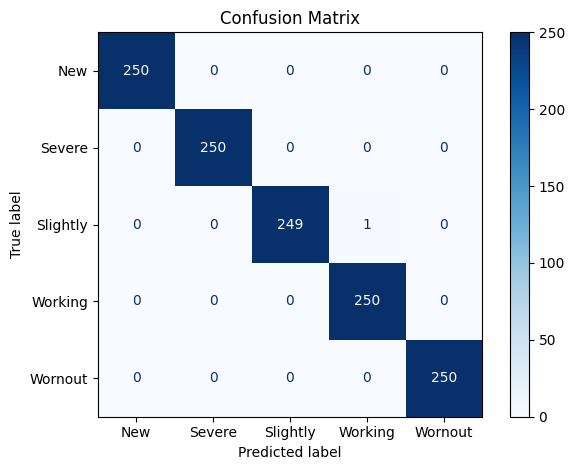

In [59]:
import numpy as np
import h5py
import pywt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# === Define wavelet transform ===
def flat_wavelet_transform2(data, method='haar'):
    if data.ndim == 1:
        data = data.reshape(1, -1)
    coeffs = pywt.wavedec2(data, method)
    output = coeffs[0].reshape(-1)
    for tups in coeffs[1:]:
        for c in tups:
            output = np.concatenate((output, c.reshape(-1)))
    return output

# === Load and process training data ===
train_path = r"C:\Users\Gurukumar\Desktop\train_dataset.h5"
with h5py.File(train_path, 'r') as f:
    X_train_raw = f['InputFeatures']['SoundPressure'][:]
    y_train_raw = f['TargetLabels']['target'][:]

# === Load and process test data ===
test_path = r"C:\Users\Gurukumar\Desktop\test_dataset.h5"
with h5py.File(test_path, 'r') as f:
    X_test_raw = f['InputFeatures']['SoundPressure'][:]
    y_test_raw = f['TargetLabels']['target'][:]

# === Decode class labels if they are bytes ===
if isinstance(y_train_raw[0], bytes):
    y_train_raw = [lbl.decode('utf-8') for lbl in y_train_raw]
if isinstance(y_test_raw[0], bytes):
    y_test_raw = [lbl.decode('utf-8') for lbl in y_test_raw]

# === Encode string class labels into numeric values ===
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)

# === Apply wavelet transform ===
X_train = flat_wavelet_transform2(X_train_raw, method='haar')
X_test = flat_wavelet_transform2(X_test_raw, method='haar')

# Ensure proper shape (2D)
if X_train.ndim == 1:
    X_train = X_train.reshape(-1, 1)
if X_test.ndim == 1:
    X_test = X_test.reshape(-1, 1)

print(f"✅ Transformed train shape: {X_train.shape}")
print(f"✅ Transformed test shape: {X_test.shape}")

# === Train Random Forest Classifier ===
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# === Predict on test set ===
y_pred = rf_model.predict(X_test)

# === Evaluate ===
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Accuracy: {accuracy:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


✅ PCA-reduced Train shape: (1250, 1)
✅ PCA-reduced Test shape: (1250, 1)

📋 Classification Report:
              precision    recall  f1-score   support

         New       1.00      1.00      1.00       250
      Severe       1.00      1.00      1.00       250
    Slightly       1.00      1.00      1.00       250
     Working       1.00      1.00      1.00       250
     Wornout       1.00      1.00      1.00       250

    accuracy                           1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250

🎯 Accuracy: 0.9992


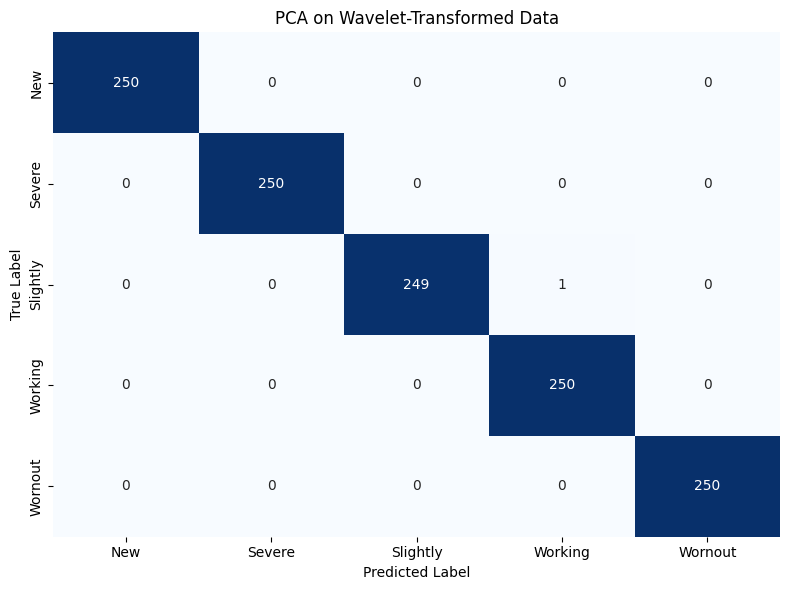

📌 Confusion matrix saved to: C:\Users\Gurukumar\Desktop\ML_output_traintest\PCA Transformed.png


In [60]:
import pandas as pd
import numpy as np
import h5py
import pywt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Define Wavelet Transform ===
def flat_wavelet_transform2(data, method='haar'):
    if data.ndim == 1:
        data = data.reshape(1, -1)
    coeffs = pywt.wavedec2(data, method)
    output = coeffs[0].reshape(-1)
    for tups in coeffs[1:]:
        for c in tups:
            output = np.concatenate((output, c.reshape(-1)))
    return output

# === Load & Transform Train Data ===
train_path = r"C:\Users\Gurukumar\Desktop\train_dataset.h5"
with h5py.File(train_path, 'r') as f:
    X_train_raw = f['InputFeatures']['SoundPressure'][:]
    y_train_raw = f['TargetLabels']['target'][:]

# === Load & Transform Test Data ===
test_path = r"C:\Users\Gurukumar\Desktop\test_dataset.h5"
with h5py.File(test_path, 'r') as f:
    X_test_raw = f['InputFeatures']['SoundPressure'][:]
    y_test_raw = f['TargetLabels']['target'][:]

# === Decode byte strings ===
if isinstance(y_train_raw[0], bytes):
    y_train_raw = [lbl.decode('utf-8') for lbl in y_train_raw]
if isinstance(y_test_raw[0], bytes):
    y_test_raw = [lbl.decode('utf-8') for lbl in y_test_raw]

# === Label Encode ===
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)

# === Apply wavelet transform ===
X_train_transformed = flat_wavelet_transform2(X_train_raw, method='haar')
X_test_transformed = flat_wavelet_transform2(X_test_raw, method='haar')

# Ensure 2D format
X_train_transformed = X_train_transformed.reshape(-1, 1) if X_train_transformed.ndim == 1 else X_train_transformed
X_test_transformed = X_test_transformed.reshape(-1, 1) if X_test_transformed.ndim == 1 else X_test_transformed

# === Standardize ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

# === Apply PCA to retain 95% variance ===
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("✅ PCA-reduced Train shape:", X_train_pca.shape)
print("✅ PCA-reduced Test shape:", X_test_pca.shape)

# === Train Random Forest Classifier ===
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train_pca, y_train)

# === Make Predictions ===
y_pred = rf_model.predict(X_test_pca)

# === Evaluation ===
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))

# === Confusion Matrix ===
conf_matrix = confusion_matrix(y_test, y_pred)

# === Plot Confusion Matrix ===
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("PCA on Wavelet-Transformed Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# === Save Plot ===
save_path = r"C:\Users\Gurukumar\Desktop\ML_output_traintest\PCA Transformed.png"
plt.tight_layout()
plt.savefig(save_path)
plt.show()

print(f"📌 Confusion matrix saved to: {save_path}")


✅ PCA-transformed Train Shape: (1250, 1)
✅ PCA-transformed Test Shape: (1250, 1)

📋 Classification Report:
              precision    recall  f1-score   support

         New       1.00      1.00      1.00       250
      Severe       1.00      1.00      1.00       250
    Slightly       1.00      1.00      1.00       250
     Working       1.00      1.00      1.00       250
     Wornout       1.00      1.00      1.00       250

    accuracy                           1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250

🎯 Accuracy: 0.9992


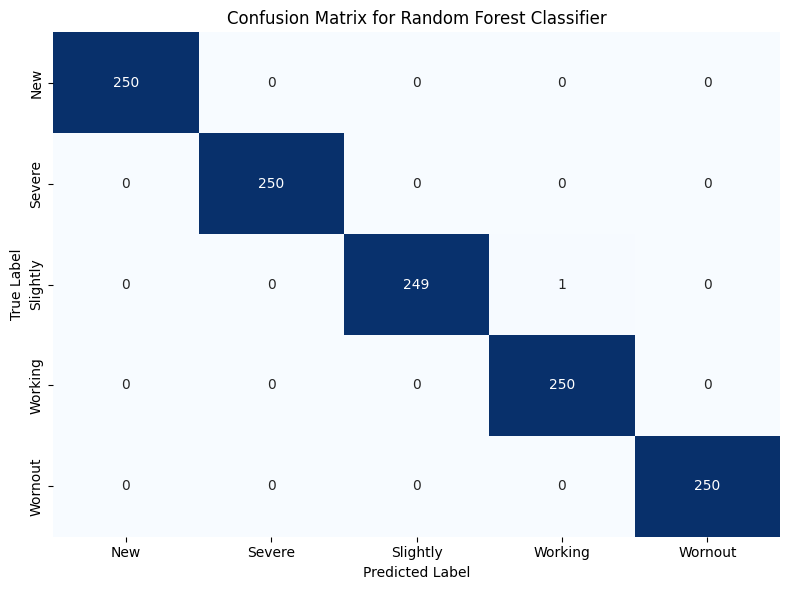

📁 Confusion matrix saved to: C:\Users\Gurukumar\Desktop\ML_output_traintest\confusion_matrix_transformpca.png


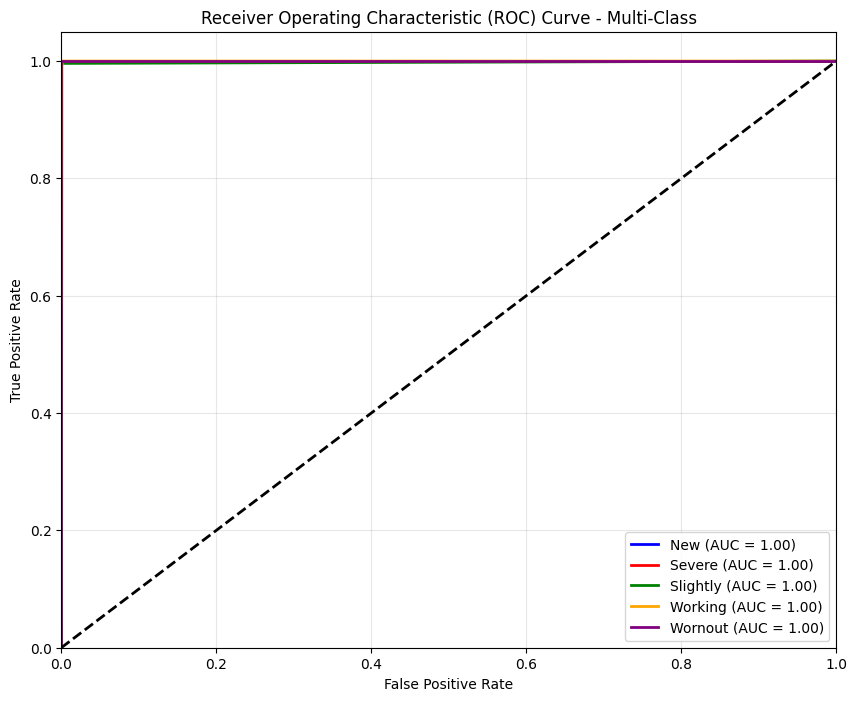

📁 ROC curve saved to: C:\Users\Gurukumar\Desktop\ML_output_traintest\roc_curve_transformpca.png


In [61]:
import numpy as np
import pandas as pd
import h5py
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

# === Wavelet Transform Function ===
def flat_wavelet_transform2(data, method='haar'):
    if data.ndim == 1:
        data = data.reshape(1, -1)
    coeffs = pywt.wavedec2(data, method)
    output = coeffs[0].reshape(-1)
    for tups in coeffs[1:]:
        for c in tups:
            output = np.concatenate((output, c.reshape(-1)))
    return output

# === Load train dataset ===
train_path = r"C:\Users\Gurukumar\Desktop\train_dataset.h5"
with h5py.File(train_path, 'r') as f:
    X_train_raw = f['InputFeatures']['SoundPressure'][:]
    y_train_raw = f['TargetLabels']['target'][:]

# === Load test dataset ===
test_path = r"C:\Users\Gurukumar\Desktop\test_dataset.h5"
with h5py.File(test_path, 'r') as f:
    X_test_raw = f['InputFeatures']['SoundPressure'][:]
    y_test_raw = f['TargetLabels']['target'][:]

# === Decode byte labels if necessary ===
if isinstance(y_train_raw[0], bytes):
    y_train_raw = [x.decode('utf-8') for x in y_train_raw]
if isinstance(y_test_raw[0], bytes):
    y_test_raw = [x.decode('utf-8') for x in y_test_raw]

# === Encode labels ===
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)

# === Apply wavelet transform ===
wavelet_method = 'haar'
X_train_transformed = flat_wavelet_transform2(X_train_raw, method=wavelet_method)
X_test_transformed = flat_wavelet_transform2(X_test_raw, method=wavelet_method)

# Reshape if 1D
X_train_transformed = X_train_transformed.reshape(-1, 1) if X_train_transformed.ndim == 1 else X_train_transformed
X_test_transformed = X_test_transformed.reshape(-1, 1) if X_test_transformed.ndim == 1 else X_test_transformed

# === Standardize ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

# === PCA: Keep 95% variance ===
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("✅ PCA-transformed Train Shape:", X_train_pca.shape)
print("✅ PCA-transformed Test Shape:", X_test_pca.shape)

# === Random Forest Classifier ===
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train_pca, y_train)

# === Predictions ===
y_pred = rf_model.predict(X_test_pca)

# === Evaluation ===
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))

# === Confusion Matrix ===
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for Random Forest Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Save the confusion matrix plot
save_path = r'C:\Users\Gurukumar\Desktop\ML_output_traintest\confusion_matrix_transformpca.png'
plt.tight_layout()
plt.savefig(save_path)
plt.show()
print(f"📁 Confusion matrix saved to: {save_path}")

# === ROC Curve (One-vs-Rest) ===
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
n_classes = y_test_bin.shape[1]

classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=0))
y_score = classifier.fit(X_train_pca, y_train).predict_proba(X_test_pca)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# === Plot ROC Curves ===
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-Class')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# Save the ROC curve
roc_save_path = r'C:\Users\Gurukumar\Desktop\ML_output_traintest\roc_curve_transformpca.png'
plt.savefig(roc_save_path)
plt.show()
print(f"📁 ROC curve saved to: {roc_save_path}")


X_train_raw shape: (1250,)
X_test_raw shape: (1250,)
Transformed train shape: (1250, 1)
Transformed test shape: (1250, 1)

✅ PCA Shapes → Train: (1250, 1)  Test: (1250, 1)

🔍 Tuning hyperparameters with Bayesian Optimization...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitti

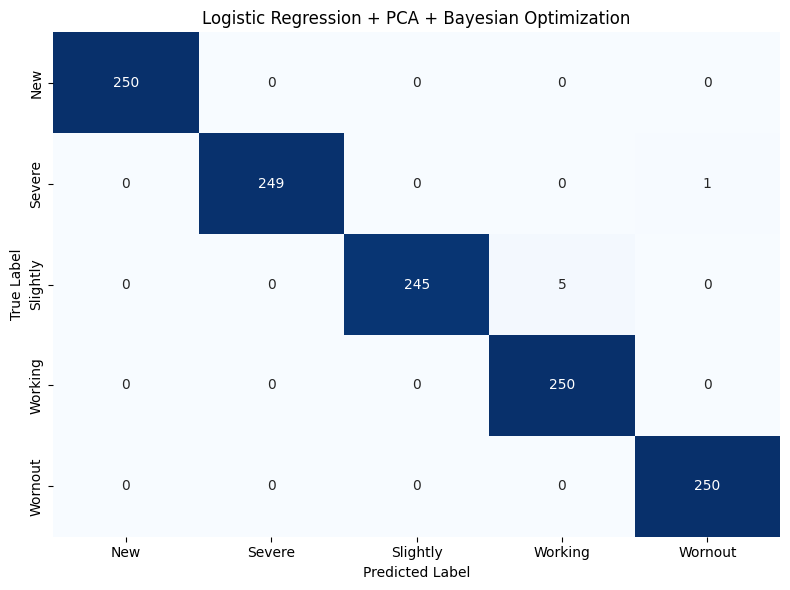

📁 Confusion matrix saved to: C:\Users\Gurukumar\Desktop\ML_output_traintest\logreg_bayes_pca.png


In [77]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skopt import BayesSearchCV

# === Load and process TRAIN data ===
train_path = r"C:\Users\Gurukumar\Desktop\train_dataset.h5"
with h5py.File(train_path, 'r') as f:
    X_train_raw = f['InputFeatures']['SoundPressure'][:]
    y_train_raw = f['TargetLabels']['target'][:]
y_train_labels = [lbl.decode('utf-8') if isinstance(lbl, bytes) else lbl for lbl in y_train_raw]

# Print shape to debug
print("X_train_raw shape:", X_train_raw.shape)

# === Load and process TEST data ===
test_path = r"C:\Users\Gurukumar\Desktop\test_dataset.h5"
with h5py.File(test_path, 'r') as f:
    X_test_raw = f['InputFeatures']['SoundPressure'][:]
    y_test_raw = f['TargetLabels']['target'][:]
y_test_labels = [lbl.decode('utf-8') if isinstance(lbl, bytes) else lbl for lbl in y_test_raw]

print("X_test_raw shape:", X_test_raw.shape)

# === Check data dimensionality and prepare features ===
# If data is 1D (scalar per sample), reshape to 2D for sklearn
if X_train_raw.ndim == 1:
    X_transformed = X_train_raw.reshape(-1, 1)
else:
    X_transformed = X_train_raw

if X_test_raw.ndim == 1:
    X_test_transformed = X_test_raw.reshape(-1, 1)
else:
    X_test_transformed = X_test_raw

print("Transformed train shape:", X_transformed.shape)
print("Transformed test shape:", X_test_transformed.shape)

# === STEP 1: Encode labels ===
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_labels)
y_test = label_encoder.transform(y_test_labels)

# === STEP 2: Standardize features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

# === STEP 3: PCA ===
# PCA may not be useful for a single feature, but included for consistency
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("\n✅ PCA Shapes → Train:", X_train_pca.shape, " Test:", X_test_pca.shape)

# === STEP 4: Logistic Regression ===
model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=300)

# === STEP 5: Bayesian Optimization ===
param_space = {
    'penalty': ['l2'],
    'C': (0.01, 100.0, 'log-uniform'),
}
bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# === STEP 6: Fit the model ===
print("\n🔍 Tuning hyperparameters with Bayesian Optimization...")
bayes_search.fit(X_train_pca, y_train)
best_model = bayes_search.best_estimator_

# === STEP 7: Predict & Evaluate ===
y_pred = best_model.predict(X_test_pca)
print("\n📜 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

accuracy = accuracy_score(y_test, y_pred)
print("🎯 Accuracy:", accuracy)
print("Best Hyperparameters:", bayes_search.best_params_)

# === STEP 8: Confusion Matrix ===
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Logistic Regression + PCA + Bayesian Optimization")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# === STEP 9: Save Plot ===
save_path = r"C:\Users\Gurukumar\Desktop\ML_output_traintest\logreg_bayes_pca.png"
plt.savefig(save_path)
plt.tight_layout()
plt.show()
print(f"📁 Confusion matrix saved to: {save_path}")

X_train_raw shape: (1250,)
X_test_raw shape: (1250,)
Transformed train shape: (1250, 1)
Transformed test shape: (1250, 1)

✅ PCA Shapes → Train: (1250, 1)  Test: (1250, 1)

🔍 Tuning hyperparameters with Bayesian Optimization...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitti

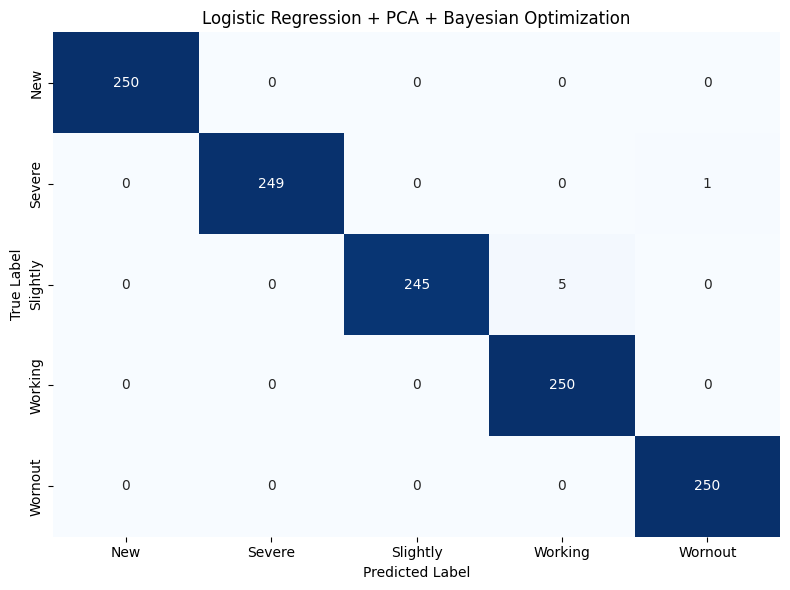

📁 Confusion matrix saved to: C:\Users\Gurukumar\Desktop\ML_output_traintest\logreg_bayes_pca.png


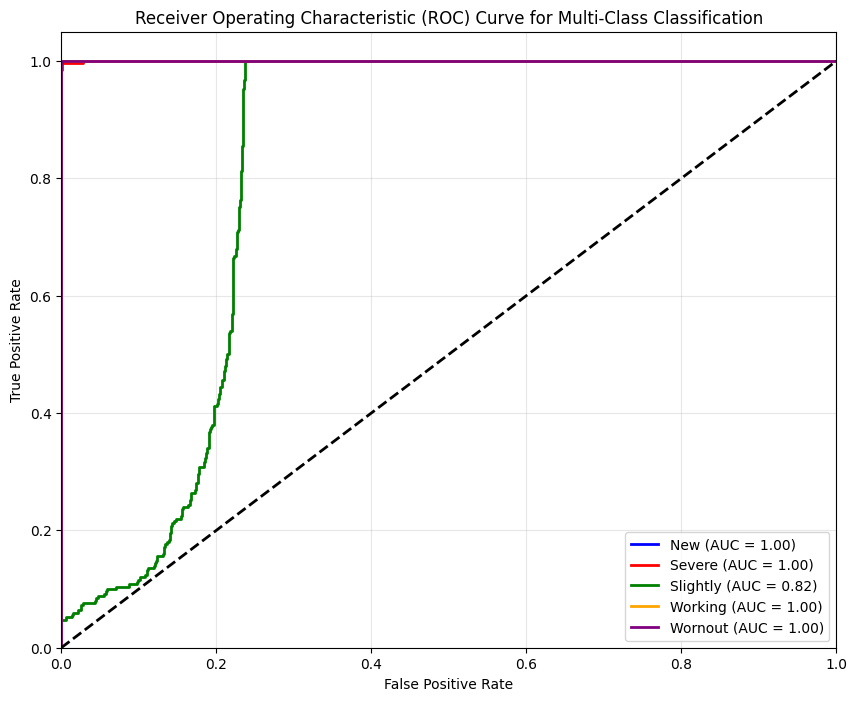

📁 ROC curve saved to: C:\Users\Gurukumar\Desktop\ML_output_traintest\roc_curve_pcahyper.png


In [78]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from skopt import BayesSearchCV

# === Load and process TRAIN data ===
train_path = r"C:\Users\Gurukumar\Desktop\train_dataset.h5"
with h5py.File(train_path, 'r') as f:
    X_train_raw = f['InputFeatures']['SoundPressure'][:]
    y_train_raw = f['TargetLabels']['target'][:]
y_train_labels = [lbl.decode('utf-8') if isinstance(lbl, bytes) else lbl for lbl in y_train_raw]

print("X_train_raw shape:", X_train_raw.shape)

# === Load and process TEST data ===
test_path = r"C:\Users\Gurukumar\Desktop\test_dataset.h5"
with h5py.File(test_path, 'r') as f:
    X_test_raw = f['InputFeatures']['SoundPressure'][:]
    y_test_raw = f['TargetLabels']['target'][:]
y_test_labels = [lbl.decode('utf-8') if isinstance(lbl, bytes) else lbl for lbl in y_test_raw]

print("X_test_raw shape:", X_test_raw.shape)

# === Check data dimensionality and prepare features ===
if X_train_raw.ndim == 1:
    X_train = X_train_raw.reshape(-1, 1)
else:
    X_train = X_train_raw

if X_test_raw.ndim == 1:
    X_test = X_test_raw.reshape(-1, 1)
else:
    X_test = X_test_raw

print("Transformed train shape:", X_train.shape)
print("Transformed test shape:", X_test.shape)

# === STEP 1: Encode labels ===
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_labels)
y_test = label_encoder.transform(y_test_labels)

# === STEP 2: Standardize features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === STEP 3: PCA ===
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("\n✅ PCA Shapes → Train:", X_train_pca.shape, " Test:", X_test_pca.shape)

# === STEP 4: Logistic Regression with Bayesian Optimization ===
model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=300)
param_space = {
    'penalty': ['l2'],
    'C': (0.01, 100.0, 'log-uniform'),
}
bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# === STEP 5: Fit the model ===
print("\n🔍 Tuning hyperparameters with Bayesian Optimization...")
bayes_search.fit(X_train_pca, y_train)
best_model = bayes_search.best_estimator_

# === STEP 6: Predict & Evaluate ===
y_pred = best_model.predict(X_test_pca)
print("\n📜 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

accuracy = accuracy_score(y_test, y_pred)
print("🎯 Accuracy:", accuracy)
print("Best Hyperparameters:", bayes_search.best_params_)

# === STEP 7: Confusion Matrix ===
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Logistic Regression + PCA + Bayesian Optimization")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
save_path = r"C:\Users\Gurukumar\Desktop\ML_output_traintest\logreg_bayes_pca.png"
plt.savefig(save_path)
plt.tight_layout()
plt.show()
print(f"📁 Confusion matrix saved to: {save_path}")

# === STEP 8: ROC Curve ===
# Binarize the output labels for ROC curve plotting
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
n_classes = y_test_bin.shape[1]

# Use the OneVsRestClassifier strategy with the best model
classifier = OneVsRestClassifier(best_model)
y_score = classifier.fit(X_train_pca, y_train).predict_proba(X_test_pca)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set the plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# Save the ROC curve plot
roc_save_path = r'C:\Users\Gurukumar\Desktop\ML_output_traintest\roc_curve_pcahyper.png'
plt.savefig(roc_save_path)
plt.show()
print(f"📁 ROC curve saved to: {roc_save_path}")

X_train_raw shape: (1250,)
X_test_raw shape: (1250,)
Transformed train shape: (1250, 1)
Transformed test shape: (1250, 1)

Principal Components (first 5 rows):
          0
0 -0.974023
1  1.341223
2  1.451526
3 -0.528664
4 -0.492581

Training Set Class Distribution:
0    250
4    250
3    250
2    250
1    250
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

         New       1.00      1.00      1.00       250
      Severe       1.00      1.00      1.00       250
    Slightly       1.00      1.00      1.00       250
     Working       1.00      1.00      1.00       250
     Wornout       1.00      1.00      1.00       250

    accuracy                           1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250

Accuracy: 0.9992
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Confusion Matrix:
[[250 

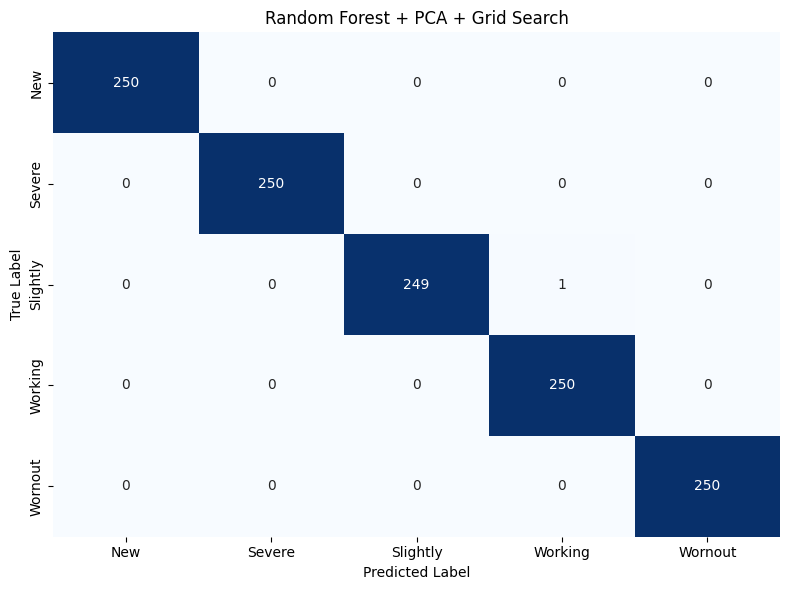

📁 Confusion matrix saved to: C:\Users\Gurukumar\Desktop\ML_output_traintest\random_transformed.png


In [79]:
import pandas as pd
import numpy as np
import h5py
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Load and process TRAIN data ===
train_path = r"C:\Users\Gurukumar\Desktop\train_dataset.h5"
with h5py.File(train_path, 'r') as f:
    X_train_raw = f['InputFeatures']['SoundPressure'][:]
    y_train_raw = f['TargetLabels']['target'][:]
y_train_labels = [lbl.decode('utf-8') if isinstance(lbl, bytes) else lbl for lbl in y_train_raw]

print("X_train_raw shape:", X_train_raw.shape)

# === Load and process TEST data ===
test_path = r"C:\Users\Gurukumar\Desktop\test_dataset.h5"
with h5py.File(test_path, 'r') as f:
    X_test_raw = f['InputFeatures']['SoundPressure'][:]
    y_test_raw = f['TargetLabels']['target'][:]
y_test_labels = [lbl.decode('utf-8') if isinstance(lbl, bytes) else lbl for lbl in y_test_raw]

print("X_test_raw shape:", X_test_raw.shape)

# === Check data dimensionality and prepare features ===
if X_train_raw.ndim == 1:
    X_train = X_train_raw.reshape(-1, 1)
else:
    X_train = X_train_raw

if X_test_raw.ndim == 1:
    X_test = X_test_raw.reshape(-1, 1)
else:
    X_test = X_test_raw

print("Transformed train shape:", X_train.shape)
print("Transformed test shape:", X_test.shape)

# === Encode labels ===
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_labels)
y_test = label_encoder.transform(y_test_labels)

# === Standardize features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Perform PCA retaining 95% of the variance ===
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("\nPrincipal Components (first 5 rows):")
principal_df = pd.DataFrame(data=X_train_pca)
print(principal_df.head())

# === Check target class distribution ===
print("\nTraining Set Class Distribution:")
print(pd.Series(y_train).value_counts())

# === Define Random Forest model ===
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# === Define hyperparameters grid for tuning ===
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# === Perform grid search with cross-validation ===
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# === Get the best model ===
best_model = grid_search.best_estimator_

# === Make predictions ===
y_pred = best_model.predict(X_test_pca)

# === Evaluate the model ===
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Best Hyperparameters:", grid_search.best_params_)

# === Confusion matrix ===
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# === Plot confusion matrix ===
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Random Forest + PCA + Grid Search")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
save_path = r"C:\Users\Gurukumar\Desktop\ML_output_traintest\random_transformed.png"
plt.savefig(save_path)
plt.tight_layout()
plt.show()
print(f"📁 Confusion matrix saved to: {save_path}")

X_train_raw shape: (1250,)
X_test_raw shape: (1250,)
Transformed train shape: (1250, 1)
Transformed test shape: (1250, 1)

Principal Components (first 5 rows):
          0
0 -0.974023
1  1.341223
2  1.451526
3 -0.528664
4 -0.492581

Training Set Class Distribution:
0    250
4    250
3    250
2    250
1    250
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

         New       1.00      0.99      1.00       250
      Severe       1.00      1.00      1.00       250
    Slightly       0.99      0.98      0.99       250
     Working       0.98      1.00      0.99       250
     Wornout       1.00      1.00      1.00       250

    accuracy                           1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250

Accuracy: 0.9952
Best Hyperparameters: {'C': 10, 'max_iter': 300, 'penalty': 'l1', 'solver': 'saga'}

Confusion Matrix:
[[248   0   2   0   0]
 [  0 2

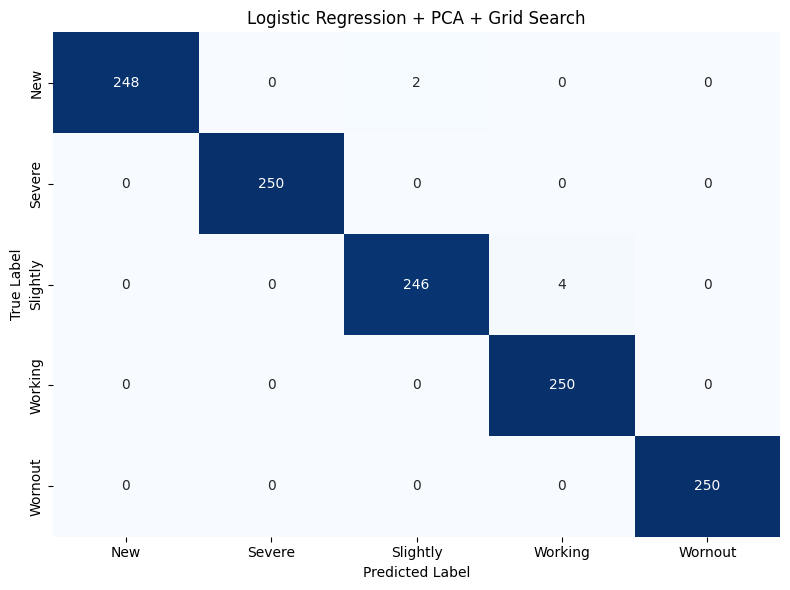

📁 Confusion matrix saved to: C:\Users\Gurukumar\Desktop\ML_output_traintest\random_transformed.png


In [80]:
import pandas as pd
import numpy as np
import h5py
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Load and process TRAIN data ===
train_path = r"C:\Users\Gurukumar\Desktop\train_dataset.h5"
with h5py.File(train_path, 'r') as f:
    X_train_raw = f['InputFeatures']['SoundPressure'][:]
    y_train_raw = f['TargetLabels']['target'][:]
y_train_labels = [lbl.decode('utf-8') if isinstance(lbl, bytes) else lbl for lbl in y_train_raw]

print("X_train_raw shape:", X_train_raw.shape)

# === Load and process TEST data ===
test_path = r"C:\Users\Gurukumar\Desktop\test_dataset.h5"
with h5py.File(test_path, 'r') as f:
    X_test_raw = f['InputFeatures']['SoundPressure'][:]
    y_test_raw = f['TargetLabels']['target'][:]
y_test_labels = [lbl.decode('utf-8') if isinstance(lbl, bytes) else lbl for lbl in y_test_raw]

print("X_test_raw shape:", X_test_raw.shape)

# === Check data dimensionality and prepare features ===
if X_train_raw.ndim == 1:
    X_train = X_train_raw.reshape(-1, 1)
else:
    X_train = X_train_raw

if X_test_raw.ndim == 1:
    X_test = X_test_raw.reshape(-1, 1)
else:
    X_test = X_test_raw

print("Transformed train shape:", X_train.shape)
print("Transformed test shape:", X_test.shape)

# === Encode labels ===
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_labels)
y_test = label_encoder.transform(y_test_labels)

# === Standardize features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Perform PCA retaining 95% of the variance ===
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("\nPrincipal Components (first 5 rows):")
principal_df = pd.DataFrame(data=X_train_pca)
print(principal_df.head())

# === Check target class distribution ===
print("\nTraining Set Class Distribution:")
print(pd.Series(y_train).value_counts())

# === Define logistic regression model ===
model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=300, class_weight='balanced')

# === Define hyperparameters grid for tuning ===
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100],
    'solver': ['saga'],
    'max_iter': [200, 300, 400]
}

# === Perform grid search with cross-validation ===
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# === Get the best model ===
best_model = grid_search.best_estimator_

# === Make predictions ===
y_pred = best_model.predict(X_test_pca)

# === Evaluate the model ===
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Best Hyperparameters:", grid_search.best_params_)

# === Confusion matrix ===
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# === Plot confusion matrix ===
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Logistic Regression + PCA + Grid Search")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
save_path = r"C:\Users\Gurukumar\Desktop\ML_output_traintest\random_transformed.png"
plt.savefig(save_path)
plt.tight_layout()
plt.show()
print(f"📁 Confusion matrix saved to: {save_path}")